In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import joblib

In [2]:
df = pd.read_csv("weatherAUS.csv")
pd.set_option("display.max_columns", None)
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,E,15.0,13.0,59.0,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No,0.0,No
142189,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,0.0,No
142190,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,0.0,No
142191,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,0.0,No


In [3]:
numerical_feature = [feature for feature in df.columns if df[feature].dtypes != 'O']
discrete_feature=[feature for feature in numerical_feature if len(df[feature].unique())<25]
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
categorical_feature = [feature for feature in df.columns if feature not in numerical_feature]
unnecessary_feature = [feature for feature in categorical_feature if len(df[feature].unique())<25]
print("Numerical Features Count {}".format(len(numerical_feature)))
print("Discrete feature Count {}".format(len(discrete_feature)))
print("Continuous feature Count {}".format(len(continuous_feature)))
print("Categorical feature Count {}".format(len(categorical_feature)))
print('Unnecessary Feature Count {}' .format(len(unnecessary_feature)))

Numerical Features Count 17
Discrete feature Count 2
Continuous feature Count 15
Categorical feature Count 7
Unnecessary Feature Count 5


In [4]:
# Handle Missing Values
df.isnull().sum()*100/len(df)

Date              0.000000
Location          0.000000
MinTemp           0.447983
MaxTemp           0.226453
Rainfall          0.988797
Evaporation      42.789026
Sunshine         47.692924
WindGustDir       6.561504
WindGustSpeed     6.519308
WindDir9am        7.041838
WindDir3pm        2.656952
WindSpeed9am      0.948007
WindSpeed3pm      1.849599
Humidity9am       1.247600
Humidity3pm       2.538803
Pressure9am       9.855619
Pressure3pm       9.832411
Cloud9am         37.735332
Cloud3pm         40.152469
Temp9am           0.635756
Temp3pm           1.917113
RainToday         0.988797
RISK_MM           0.000000
RainTomorrow      0.000000
dtype: float64

In [5]:
#Filling the missing values with values from the observable non-missing data.
def randomsampleimputation(df, variable):
    random_sample=df[variable].dropna().sample(df[variable].isnull().sum(),random_state=0)
    random_sample.index=df[df[variable].isnull()].index
    df.loc[df[variable].isnull(),variable]=random_sample #replacing the random variables with the missing variable


In [6]:
randomsampleimputation(df, "Cloud9am")
randomsampleimputation(df, "Cloud3pm")
randomsampleimputation(df, "Evaporation")
randomsampleimputation(df, "Sunshine")

In [7]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,6.2,3.3,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,0.4,6.1,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,5.0,1.0,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,5.8,9.7,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,1.0,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,1.4,12.2,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,7.0,7.0,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,6.6,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,2017-06-20,Uluru,3.5,21.8,0.0,16.0,6.6,E,31.0,ESE,E,15.0,13.0,59.0,27.0,1024.7,1021.2,7.0,7.0,9.4,20.9,No,0.0,No
142189,2017-06-21,Uluru,2.8,23.4,0.0,1.0,11.4,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,8.0,10.1,22.4,No,0.0,No
142190,2017-06-22,Uluru,3.6,25.3,0.0,6.7,2.4,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,7.0,0.0,10.9,24.5,No,0.0,No
142191,2017-06-23,Uluru,5.4,26.9,0.0,5.6,0.0,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,0.0,8.0,12.5,26.1,No,0.0,No


C:\Users\Idowu Mariam\AppData\Local\Temp\ipykernel_22704\2689263927.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = df.corr(method = "spearman")


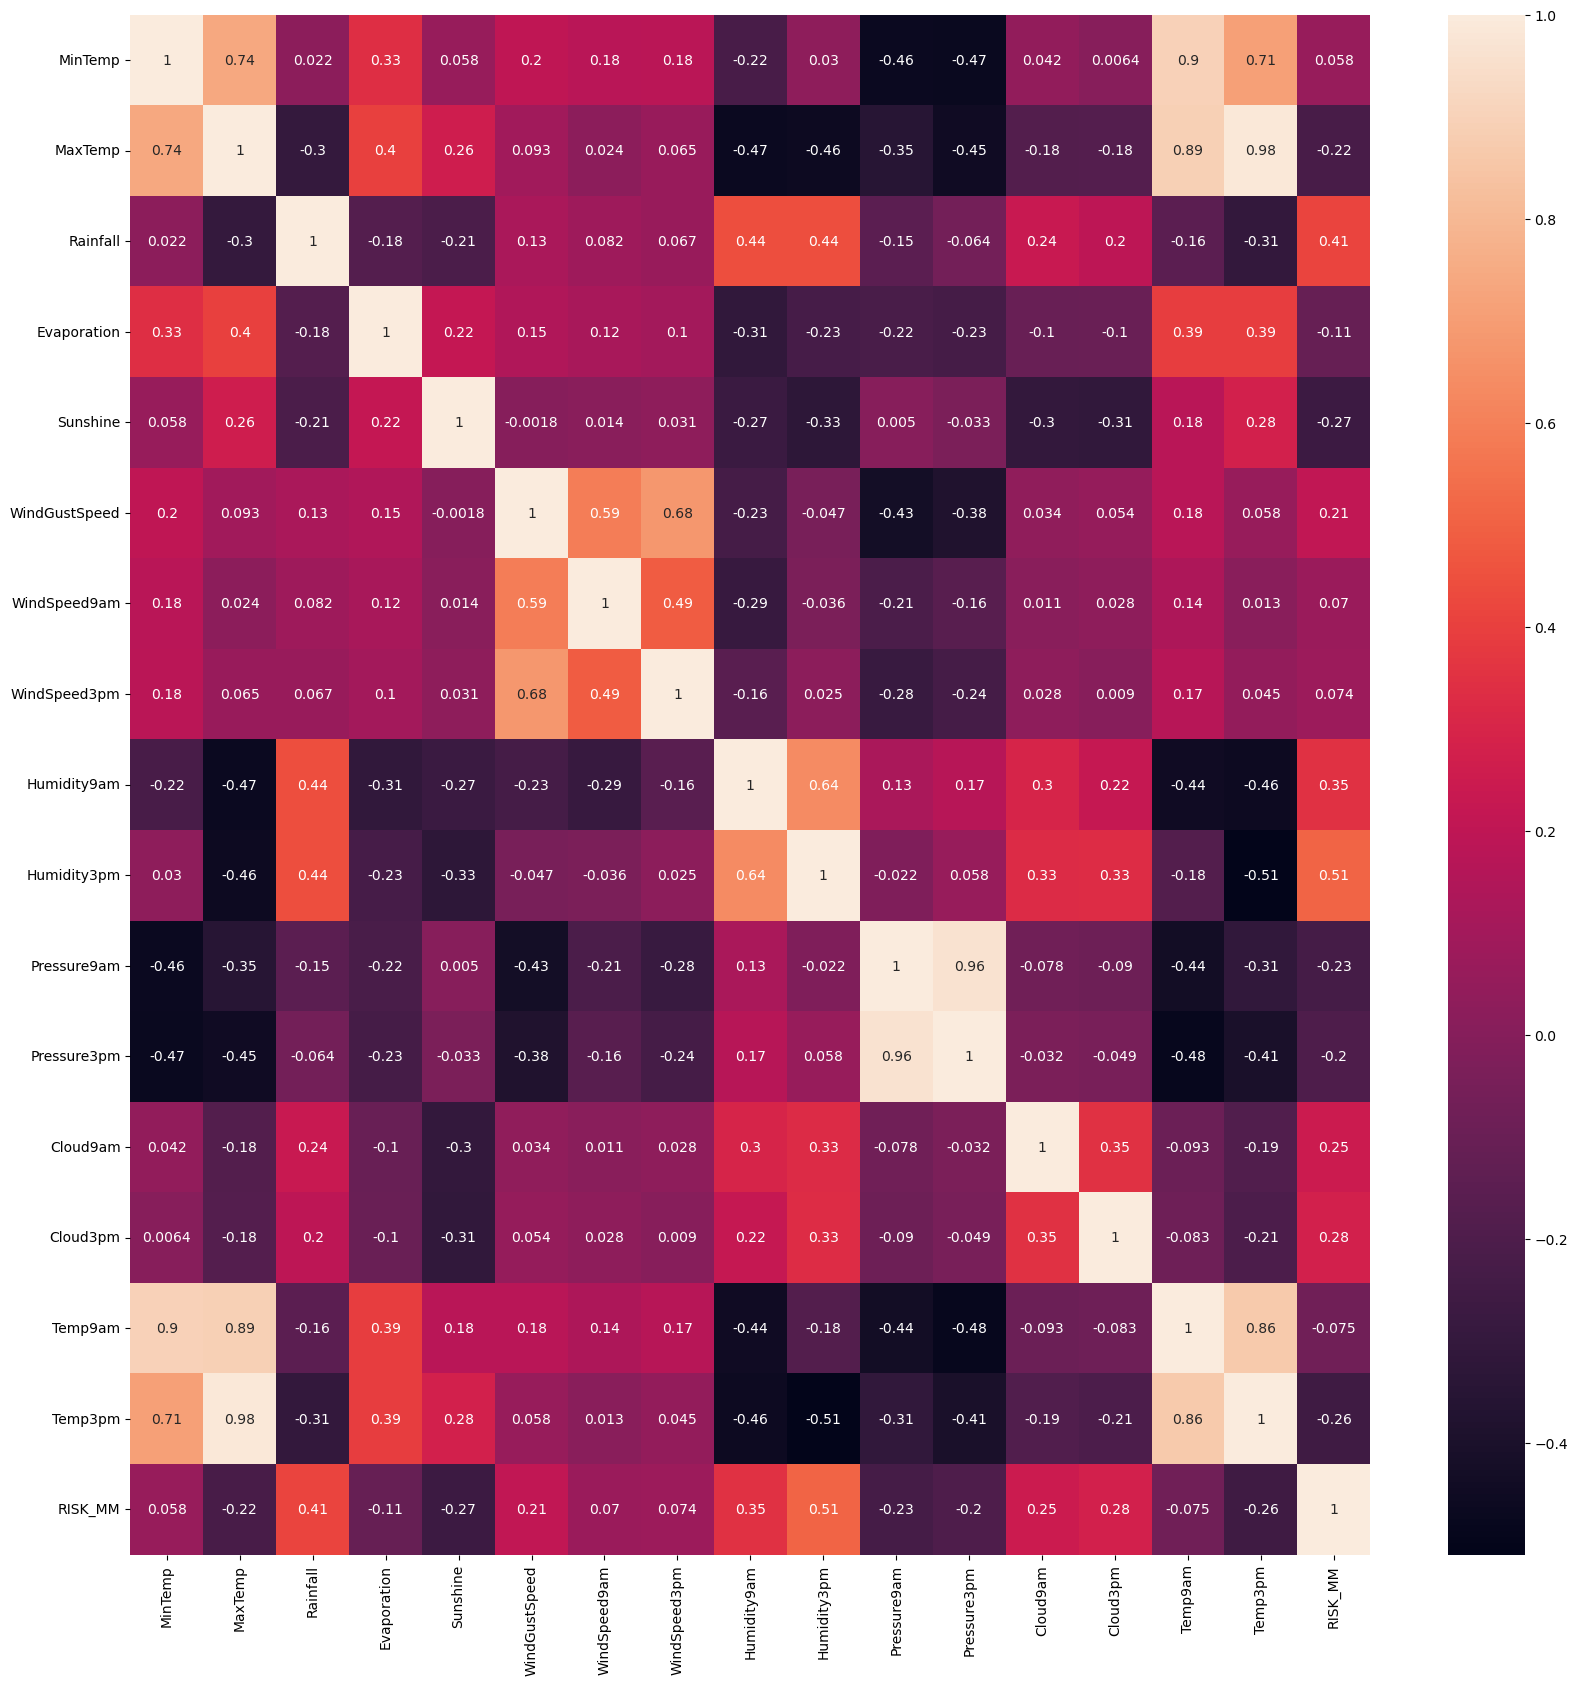

In [8]:
corrmat = df.corr(method = "spearman")
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(corrmat,annot=True)

C:\Users\Idowu Mariam\AppData\Local\Temp\ipykernel_22704\4266842732.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], hist=False)  # Create a distribution plot for the current feature


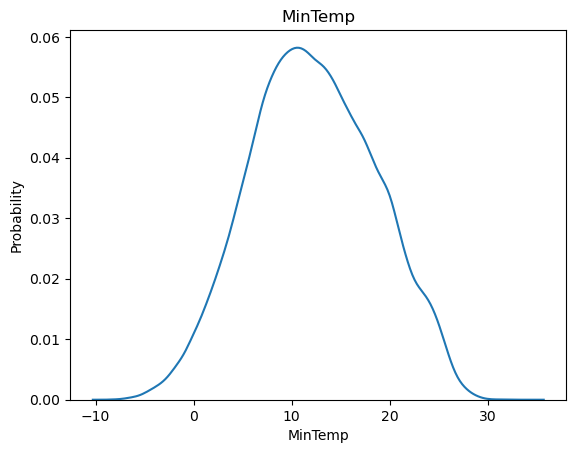

<Figure size 1500x1500 with 0 Axes>

C:\Users\Idowu Mariam\AppData\Local\Temp\ipykernel_22704\4266842732.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], hist=False)  # Create a distribution plot for the current feature


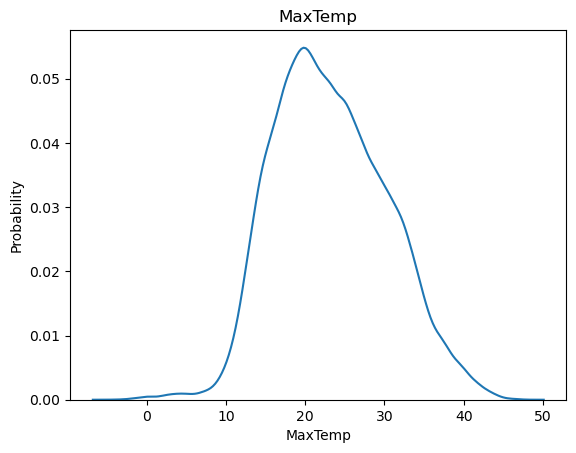

<Figure size 1500x1500 with 0 Axes>

C:\Users\Idowu Mariam\AppData\Local\Temp\ipykernel_22704\4266842732.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], hist=False)  # Create a distribution plot for the current feature


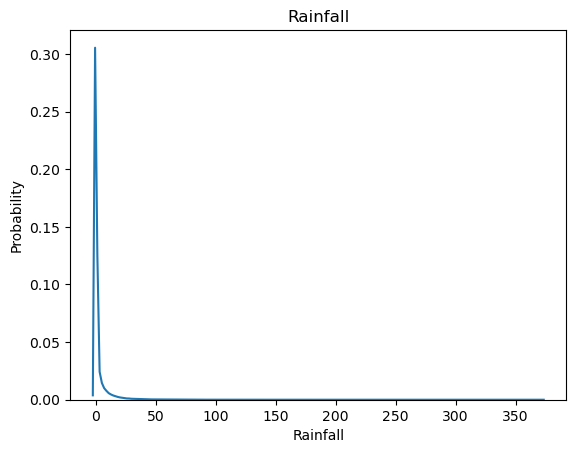

<Figure size 1500x1500 with 0 Axes>

C:\Users\Idowu Mariam\AppData\Local\Temp\ipykernel_22704\4266842732.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], hist=False)  # Create a distribution plot for the current feature


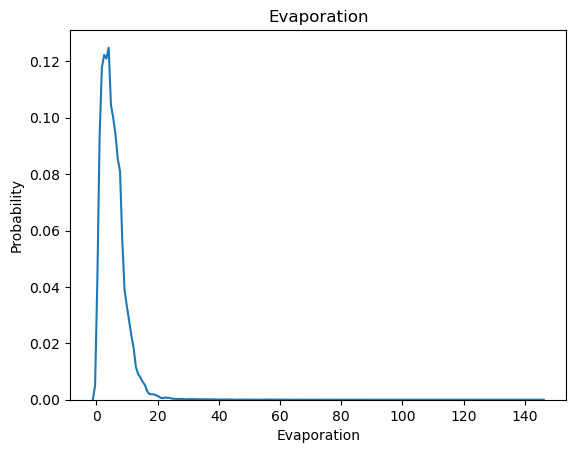

<Figure size 1500x1500 with 0 Axes>

C:\Users\Idowu Mariam\AppData\Local\Temp\ipykernel_22704\4266842732.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], hist=False)  # Create a distribution plot for the current feature


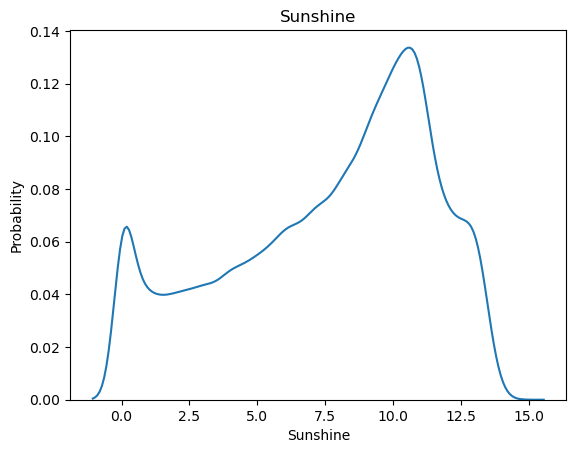

<Figure size 1500x1500 with 0 Axes>

C:\Users\Idowu Mariam\AppData\Local\Temp\ipykernel_22704\4266842732.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], hist=False)  # Create a distribution plot for the current feature


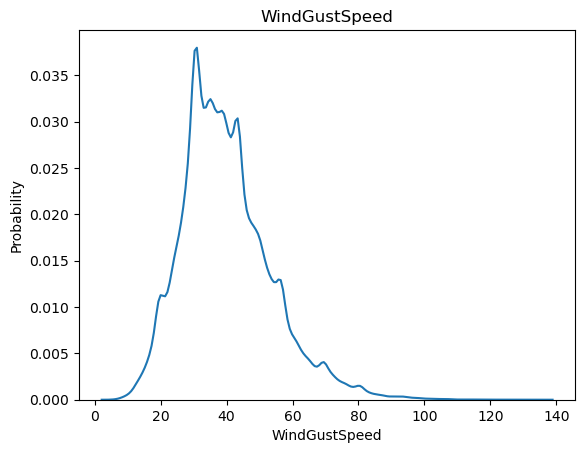

<Figure size 1500x1500 with 0 Axes>

C:\Users\Idowu Mariam\AppData\Local\Temp\ipykernel_22704\4266842732.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], hist=False)  # Create a distribution plot for the current feature


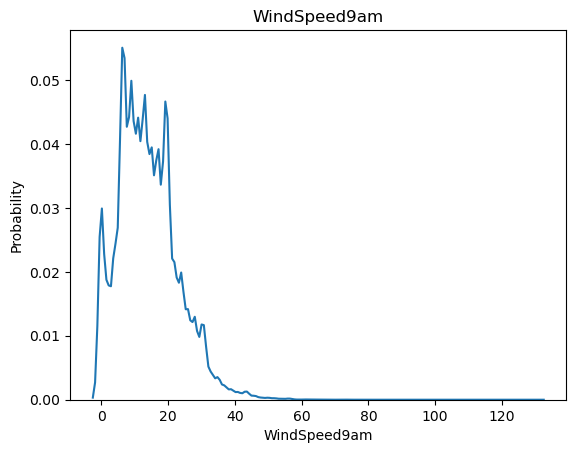

<Figure size 1500x1500 with 0 Axes>

C:\Users\Idowu Mariam\AppData\Local\Temp\ipykernel_22704\4266842732.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], hist=False)  # Create a distribution plot for the current feature


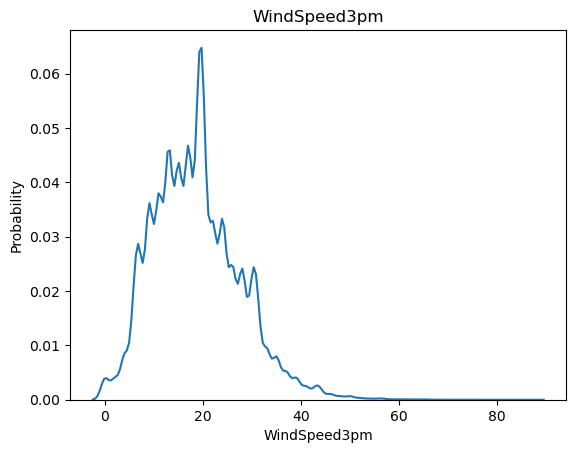

<Figure size 1500x1500 with 0 Axes>

C:\Users\Idowu Mariam\AppData\Local\Temp\ipykernel_22704\4266842732.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], hist=False)  # Create a distribution plot for the current feature


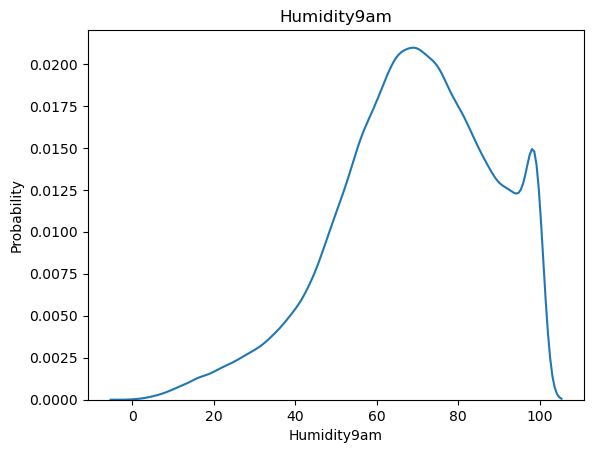

<Figure size 1500x1500 with 0 Axes>

C:\Users\Idowu Mariam\AppData\Local\Temp\ipykernel_22704\4266842732.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], hist=False)  # Create a distribution plot for the current feature


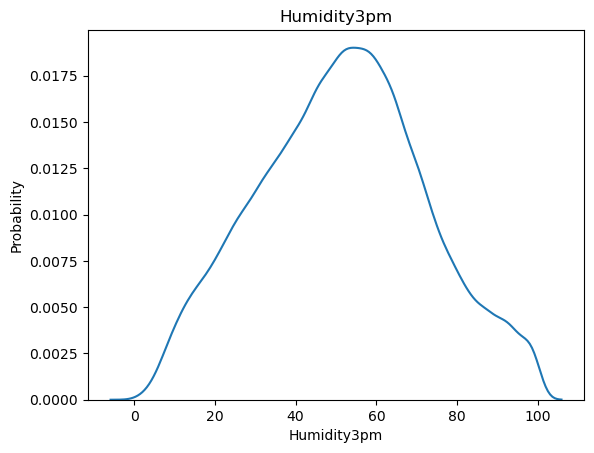

<Figure size 1500x1500 with 0 Axes>

C:\Users\Idowu Mariam\AppData\Local\Temp\ipykernel_22704\4266842732.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], hist=False)  # Create a distribution plot for the current feature


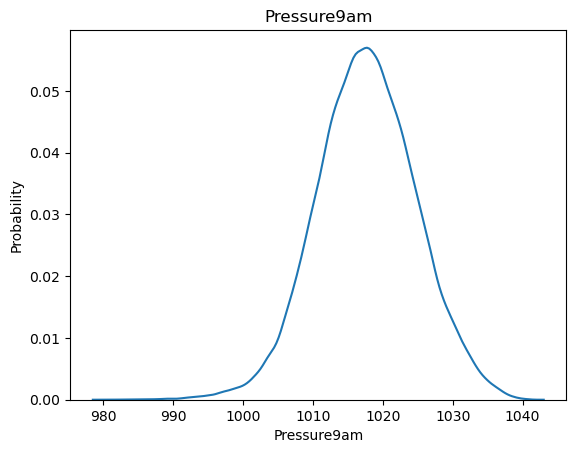

<Figure size 1500x1500 with 0 Axes>

C:\Users\Idowu Mariam\AppData\Local\Temp\ipykernel_22704\4266842732.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], hist=False)  # Create a distribution plot for the current feature


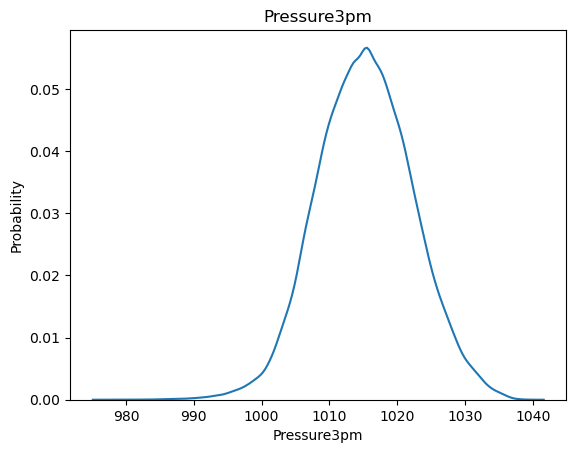

<Figure size 1500x1500 with 0 Axes>

C:\Users\Idowu Mariam\AppData\Local\Temp\ipykernel_22704\4266842732.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], hist=False)  # Create a distribution plot for the current feature


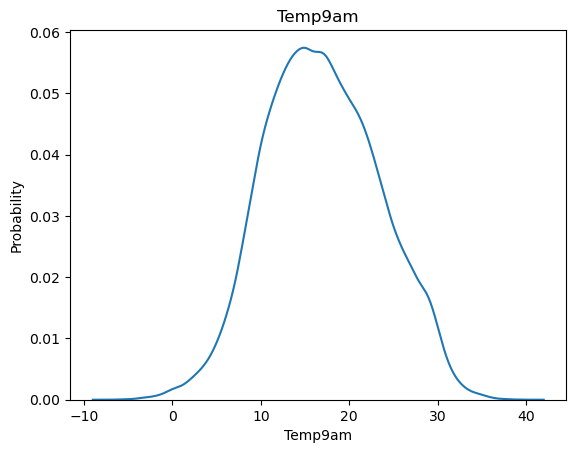

<Figure size 1500x1500 with 0 Axes>

C:\Users\Idowu Mariam\AppData\Local\Temp\ipykernel_22704\4266842732.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], hist=False)  # Create a distribution plot for the current feature


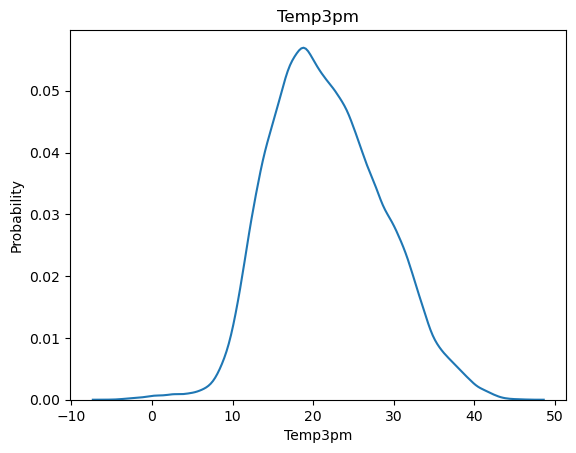

<Figure size 1500x1500 with 0 Axes>

C:\Users\Idowu Mariam\AppData\Local\Temp\ipykernel_22704\4266842732.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], hist=False)  # Create a distribution plot for the current feature


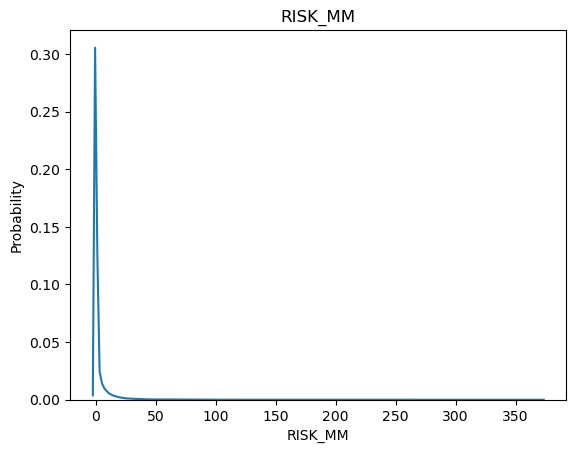

<Figure size 1500x1500 with 0 Axes>

In [9]:
for feature in continuous_feature:
    data = df.copy()  # Create a copy of the DataFrame
    sns.distplot(data[feature], hist=False)  # Create a distribution plot for the current feature
    plt.xlabel(feature)  # Set the x-axis label to the current feature
    plt.ylabel("Probability")  # Set the y-axis label to "Probability"
    plt.title(feature)  # Set the title of the plot to the current feature
    plt.figure(figsize=(15, 15))  # Set the size of the figure to 15x15 inches
    plt.show()  # Display the plot

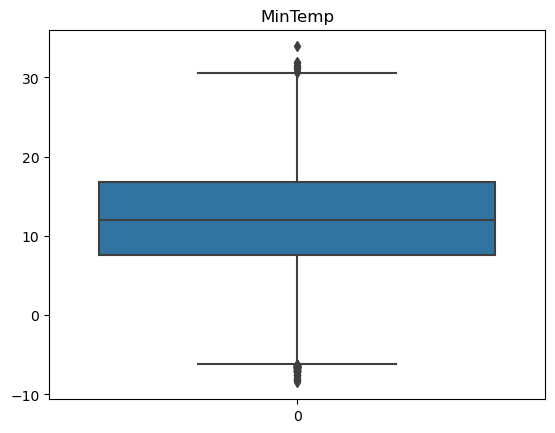

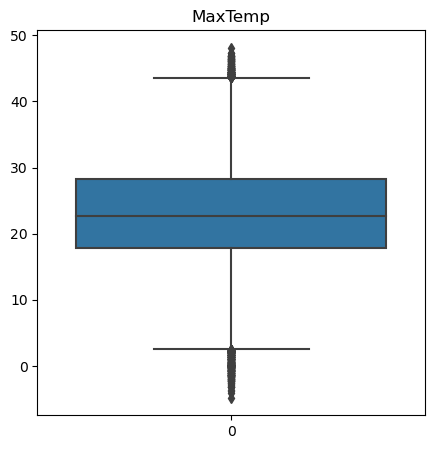

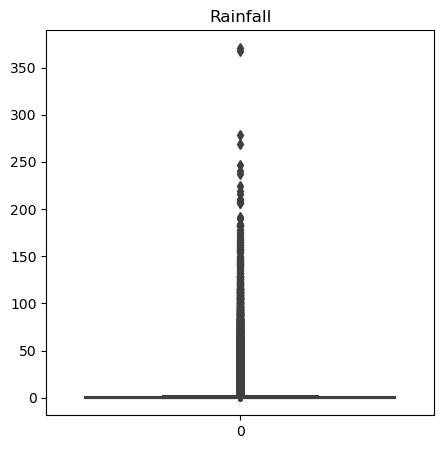

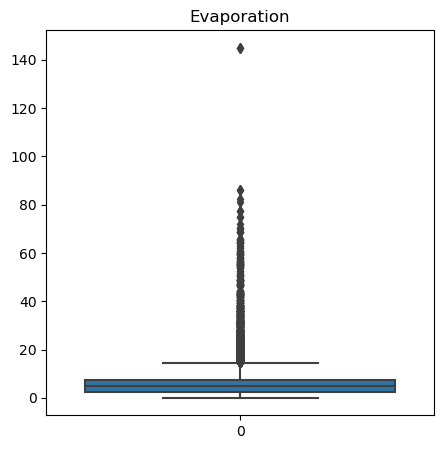

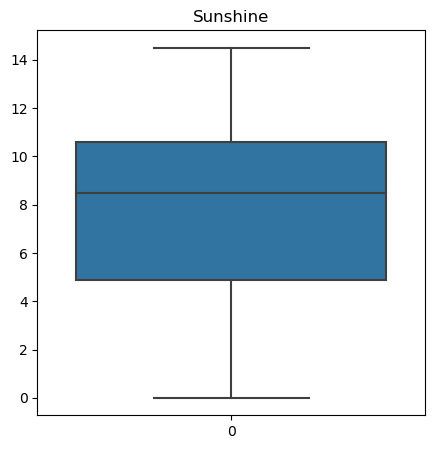

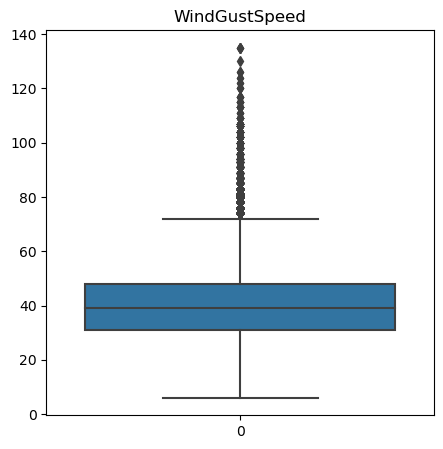

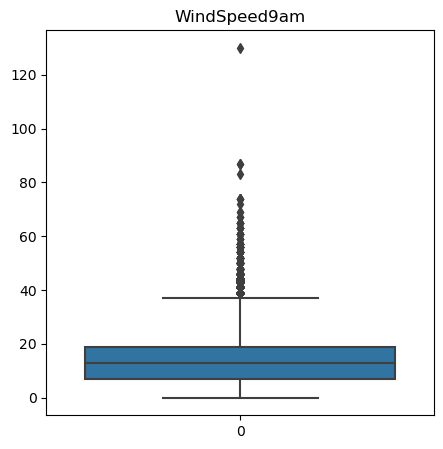

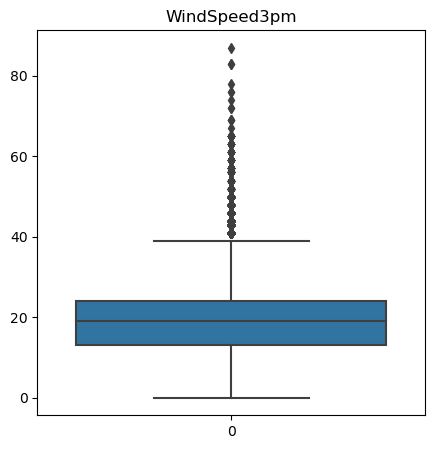

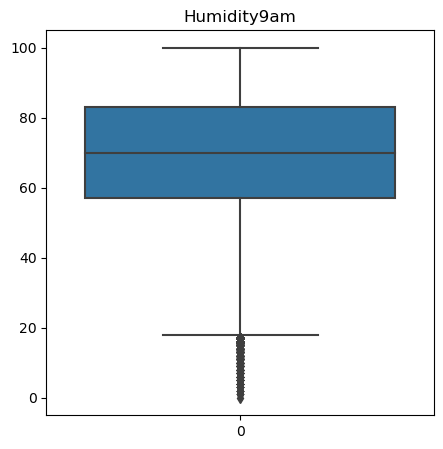

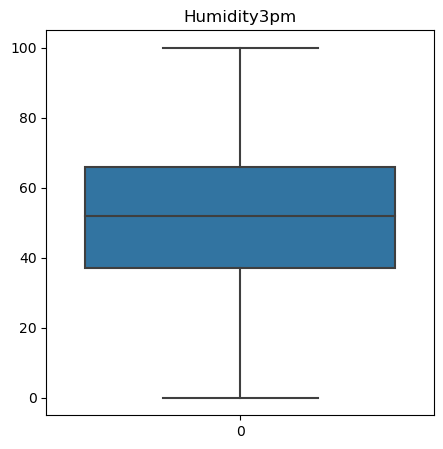

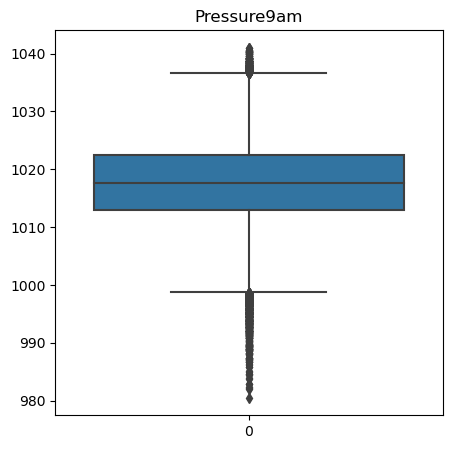

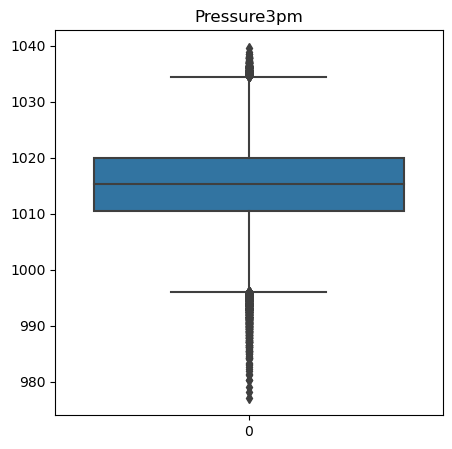

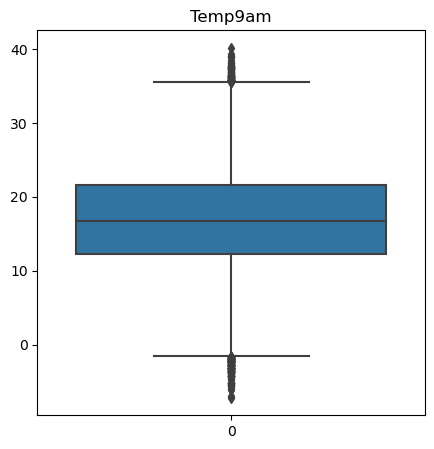

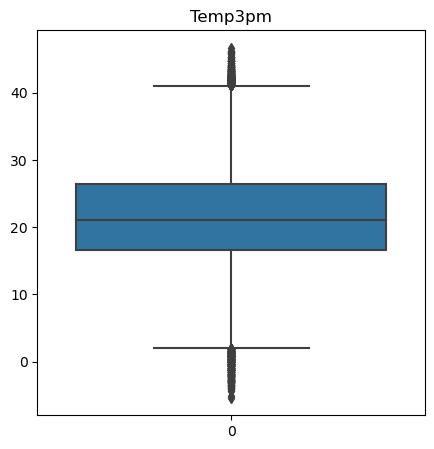

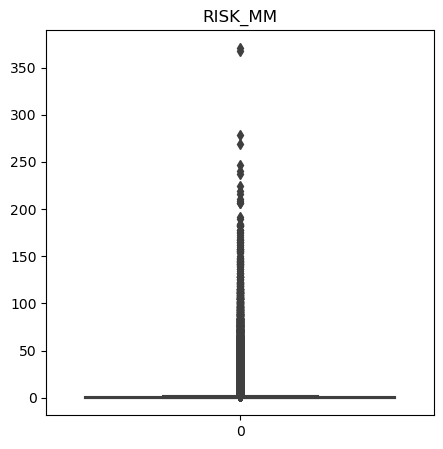

<Figure size 500x500 with 0 Axes>

In [10]:
#A for loop is used to plot a boxplot for all the continuous features to see the outliers
for feature in continuous_feature:
    data=df.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(5,5))

In [11]:
#To fill the missing values in the continous Features
for feature in continuous_feature:
    if(df[feature].isnull().sum()*100/len(df))>0:
        df[feature] = df[feature].fillna(df[feature].median())

In [12]:
df.isnull().sum()*100/len(df)

Date             0.000000
Location         0.000000
MinTemp          0.000000
MaxTemp          0.000000
Rainfall         0.000000
Evaporation      0.000000
Sunshine         0.000000
WindGustDir      6.561504
WindGustSpeed    0.000000
WindDir9am       7.041838
WindDir3pm       2.656952
WindSpeed9am     0.000000
WindSpeed3pm     0.000000
Humidity9am      0.000000
Humidity3pm      0.000000
Pressure9am      0.000000
Pressure3pm      0.000000
Cloud9am         0.000000
Cloud3pm         0.000000
Temp9am          0.000000
Temp3pm          0.000000
RainToday        0.988797
RISK_MM          0.000000
RainTomorrow     0.000000
dtype: float64

In [13]:
# To fill the missing values with the discrete variables with the mode.
def median_nan(df, variable):
    median = df[variable].value_counts().index[0]  # Calculate the mode of the variable
    df[variable].fillna(median, inplace=True)  # Fill missing values with the mode

discrete_feature

['Cloud9am', 'Cloud3pm']

In [14]:
median_nan(df,'Cloud9am')
median_nan(df,'Cloud3pm')

In [15]:
# To replace the categorical variables yes and No to binary 0 and 1, the drop_first=True to aviod mult-collinearity.

df["RainToday"] = pd.get_dummies(df["RainToday"], drop_first=True)
df["RainTomorrow"] = pd.get_dummies(df["RainTomorrow"], drop_first=True)
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,6.2,3.3,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8,0,0.0,0
1,2008-12-02,Albury,7.4,25.1,0.0,0.4,6.1,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,5.0,1.0,17.2,24.3,0,0.0,0
2,2008-12-03,Albury,12.9,25.7,0.0,5.8,9.7,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,1.0,2.0,21.0,23.2,0,0.0,0
3,2008-12-04,Albury,9.2,28.0,0.0,1.4,12.2,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,7.0,7.0,18.1,26.5,0,1.0,0
4,2008-12-05,Albury,17.5,32.3,1.0,6.6,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0.2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,2017-06-20,Uluru,3.5,21.8,0.0,16.0,6.6,E,31.0,ESE,E,15.0,13.0,59.0,27.0,1024.7,1021.2,7.0,7.0,9.4,20.9,0,0.0,0
142189,2017-06-21,Uluru,2.8,23.4,0.0,1.0,11.4,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,8.0,10.1,22.4,0,0.0,0
142190,2017-06-22,Uluru,3.6,25.3,0.0,6.7,2.4,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,7.0,0.0,10.9,24.5,0,0.0,0
142191,2017-06-23,Uluru,5.4,26.9,0.0,5.6,0.0,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,0.0,8.0,12.5,26.1,0,0.0,0


In [16]:
for feature in categorical_feature:
    print(feature, (df.groupby([feature])["RainTomorrow"].mean().sort_values(ascending = False)).index)

Date Index(['2007-11-01', '2007-12-27', '2007-12-01', '2008-04-13', '2007-12-03',
       '2008-03-25', '2008-03-07', '2007-12-07', '2008-02-28', '2008-02-12',
       ...
       '2007-12-26', '2011-10-11', '2008-04-30', '2007-12-25', '2008-05-01',
       '2008-05-02', '2008-05-03', '2008-05-04', '2008-05-05', '2008-05-24'],
      dtype='object', name='Date', length=3436)
Location Index(['Portland', 'Walpole', 'Cairns', 'Dartmoor', 'NorfolkIsland',
       'MountGambier', 'Albany', 'Witchcliffe', 'CoffsHarbour', 'MountGinini',
       'NorahHead', 'Williamtown', 'Darwin', 'Melbourne', 'GoldCoast',
       'Sydney', 'Ballarat', 'SydneyAirport', 'Newcastle', 'Watsonia',
       'Wollongong', 'Hobart', 'Launceston', 'Brisbane', 'Adelaide',
       'MelbourneAirport', 'Sale', 'Albury', 'Perth', 'Penrith',
       'BadgerysCreek', 'Nuriootpa', 'Richmond', 'Tuggeranong', 'PerthAirport',
       'Bendigo', 'Canberra', 'PearceRAAF', 'WaggaWagga', 'Townsville',
       'Katherine', 'SalmonGums', 'Nhil', 

In [17]:
#Convert the categorical variables into numerical values, a dictionary is created based off the results from the previous code assigning the highest mean associated with rain tomorrow with 0 and vice-versa.

windgustdir = {'NW':0, 'NNW':1, 'WNW':2, 'N':3, 'W':4, 'WSW':5, 'NNE':6, 'S':7, 'SSW':8, 'SW':9, 'SSE':10,
       'NE':11, 'SE':12, 'ESE':13, 'ENE':14, 'E':15}
winddir9am = {'NNW':0, 'N':1, 'NW':2, 'WNW':3, 'NNE':4, 'W':5, 'WSW':6, 'SW':7, 'SSW':8, 'NE':9, 'S':10,
       'SSE':11, 'ENE':12, 'SE':13, 'ESE':14, 'E':15}
winddir3pm = {'NNW':1, 'NW':1, 'N':2, 'WNW':3, 'W':4, 'NNE':5, 'WSW':6, 'SSW':7, 'S':8, 'SW':9, 'SSE':10,
       'SE':11, 'NE':12, 'ENE':13, 'E':14, 'ESE':15}
df["WindGustDir"] = df["WindGustDir"].map(windgustdir)
df["WindDir9am"] = df["WindDir9am"].map(winddir9am)
df["WindDir3pm"] = df["WindDir3pm"].map(winddir3pm)

In [18]:

# Fill the missing values with the created dictionary values
df["WindGustDir"] = df["WindGustDir"].fillna(df["WindGustDir"].value_counts().index[0])
df["WindDir9am"] = df["WindDir9am"].fillna(df["WindDir9am"].value_counts().index[0])
df["WindDir3pm"] = df["WindDir3pm"].fillna(df["WindDir3pm"].value_counts().index[0])

In [19]:
df.isnull().sum()*100/len(df)

Date             0.0
Location         0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
Evaporation      0.0
Sunshine         0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Cloud9am         0.0
Cloud3pm         0.0
Temp9am          0.0
Temp3pm          0.0
RainToday        0.0
RISK_MM          0.0
RainTomorrow     0.0
dtype: float64

In [20]:
df1 = df.groupby(["Location"])["RainTomorrow"].value_counts().sort_values().unstack()
df1

RainTomorrow,0,1
Location,,
Adelaide,2402,688
Albany,2114,902
Albury,2393,618
AliceSprings,2787,244
BadgerysCreek,2345,583
Ballarat,2247,781
Bendigo,2472,562
Brisbane,2452,709
Cairns,2038,950


In [21]:
df1[1].sort_values(ascending = False)

Location
Portland            1095
Cairns               950
Walpole              949
Dartmoor             922
MountGambier         920
NorfolkIsland        919
Albany               902
Witchcliffe          879
CoffsHarbour         869
Sydney               865
Darwin               852
MountGinini          819
NorahHead            808
Ballarat             781
GoldCoast            775
SydneyAirport        774
Hobart               761
Watsonia             738
Newcastle            731
Wollongong           713
Brisbane             709
Williamtown          700
Launceston           699
Adelaide             688
MelbourneAirport     653
Perth                645
Sale                 643
Melbourne            636
Canberra             629
Albury               618
Penrith              595
Nuriootpa            592
BadgerysCreek        583
Tuggeranong          568
PerthAirport         567
Bendigo              562
Richmond             560
WaggaWagga           536
Townsville           519
PearceRAAF      

In [22]:
len(df1[1].sort_values(ascending = False).index)

49

In [23]:
#Change the location Categorical data into numerical data by creating a dictionary, then using its occurence(Rain Tomorrow; Since Portland occurs the most in rain tommorrow, assign one to it) to assign it values.

location = {'Portland':1, 'Cairns':2, 'Walpole':3, 'Dartmoor':4, 'MountGambier':5,
       'NorfolkIsland':6, 'Albany':7, 'Witchcliffe':8, 'CoffsHarbour':9, 'Sydney':10,
       'Darwin':11, 'MountGinini':12, 'NorahHead':13, 'Ballarat':14, 'GoldCoast':15,
       'SydneyAirport':16, 'Hobart':17, 'Watsonia':18, 'Newcastle':19, 'Wollongong':20,
       'Brisbane':21, 'Williamtown':22, 'Launceston':23, 'Adelaide':24, 'MelbourneAirport':25,
       'Perth':26, 'Sale':27, 'Melbourne':28, 'Canberra':29, 'Albury':30, 'Penrith':31,
       'Nuriootpa':32, 'BadgerysCreek':33, 'Tuggeranong':34, 'PerthAirport':35, 'Bendigo':36,
       'Richmond':37, 'WaggaWagga':38, 'Townsville':39, 'PearceRAAF':40, 'SalmonGums':41,
       'Moree':42, 'Cobar':43, 'Mildura':44, 'Katherine':45, 'AliceSprings':46, 'Nhil':47,
       'Woomera':48, 'Uluru':49}
df["Location"] = df["Location"].map(location)

In [24]:

df["Date"] = pd.to_datetime(df["Date"], format = "%Y-%m-%dT", errors = "coerce")

In [25]:
df["Date_month"] = df["Date"].dt.month
df["Date_day"] = df["Date"].dt.day

In [26]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,Date_month,Date_day
0,2008-12-01,30,13.4,22.9,0.6,6.2,3.3,4.0,44.0,5.0,3.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8,0,0.0,0,12,1
1,2008-12-02,30,7.4,25.1,0.0,0.4,6.1,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.6,1007.8,5.0,1.0,17.2,24.3,0,0.0,0,12,2
2,2008-12-03,30,12.9,25.7,0.0,5.8,9.7,5.0,46.0,5.0,6.0,19.0,26.0,38.0,30.0,1007.6,1008.7,1.0,2.0,21.0,23.2,0,0.0,0,12,3
3,2008-12-04,30,9.2,28.0,0.0,1.4,12.2,11.0,24.0,13.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,7.0,7.0,18.1,26.5,0,1.0,0,12,4
4,2008-12-05,30,17.5,32.3,1.0,6.6,1.0,4.0,41.0,12.0,1.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0.2,0,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,2017-06-20,49,3.5,21.8,0.0,16.0,6.6,15.0,31.0,14.0,14.0,15.0,13.0,59.0,27.0,1024.7,1021.2,7.0,7.0,9.4,20.9,0,0.0,0,6,20
142189,2017-06-21,49,2.8,23.4,0.0,1.0,11.4,15.0,31.0,13.0,13.0,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,8.0,10.1,22.4,0,0.0,0,6,21
142190,2017-06-22,49,3.6,25.3,0.0,6.7,2.4,1.0,22.0,13.0,2.0,13.0,9.0,56.0,21.0,1023.5,1019.1,7.0,0.0,10.9,24.5,0,0.0,0,6,22
142191,2017-06-23,49,5.4,26.9,0.0,5.6,0.0,3.0,37.0,13.0,3.0,9.0,9.0,53.0,24.0,1021.0,1016.8,0.0,8.0,12.5,26.1,0,0.0,0,6,23


C:\Users\Idowu Mariam\AppData\Local\Temp\ipykernel_22704\3423568062.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = df.corr()


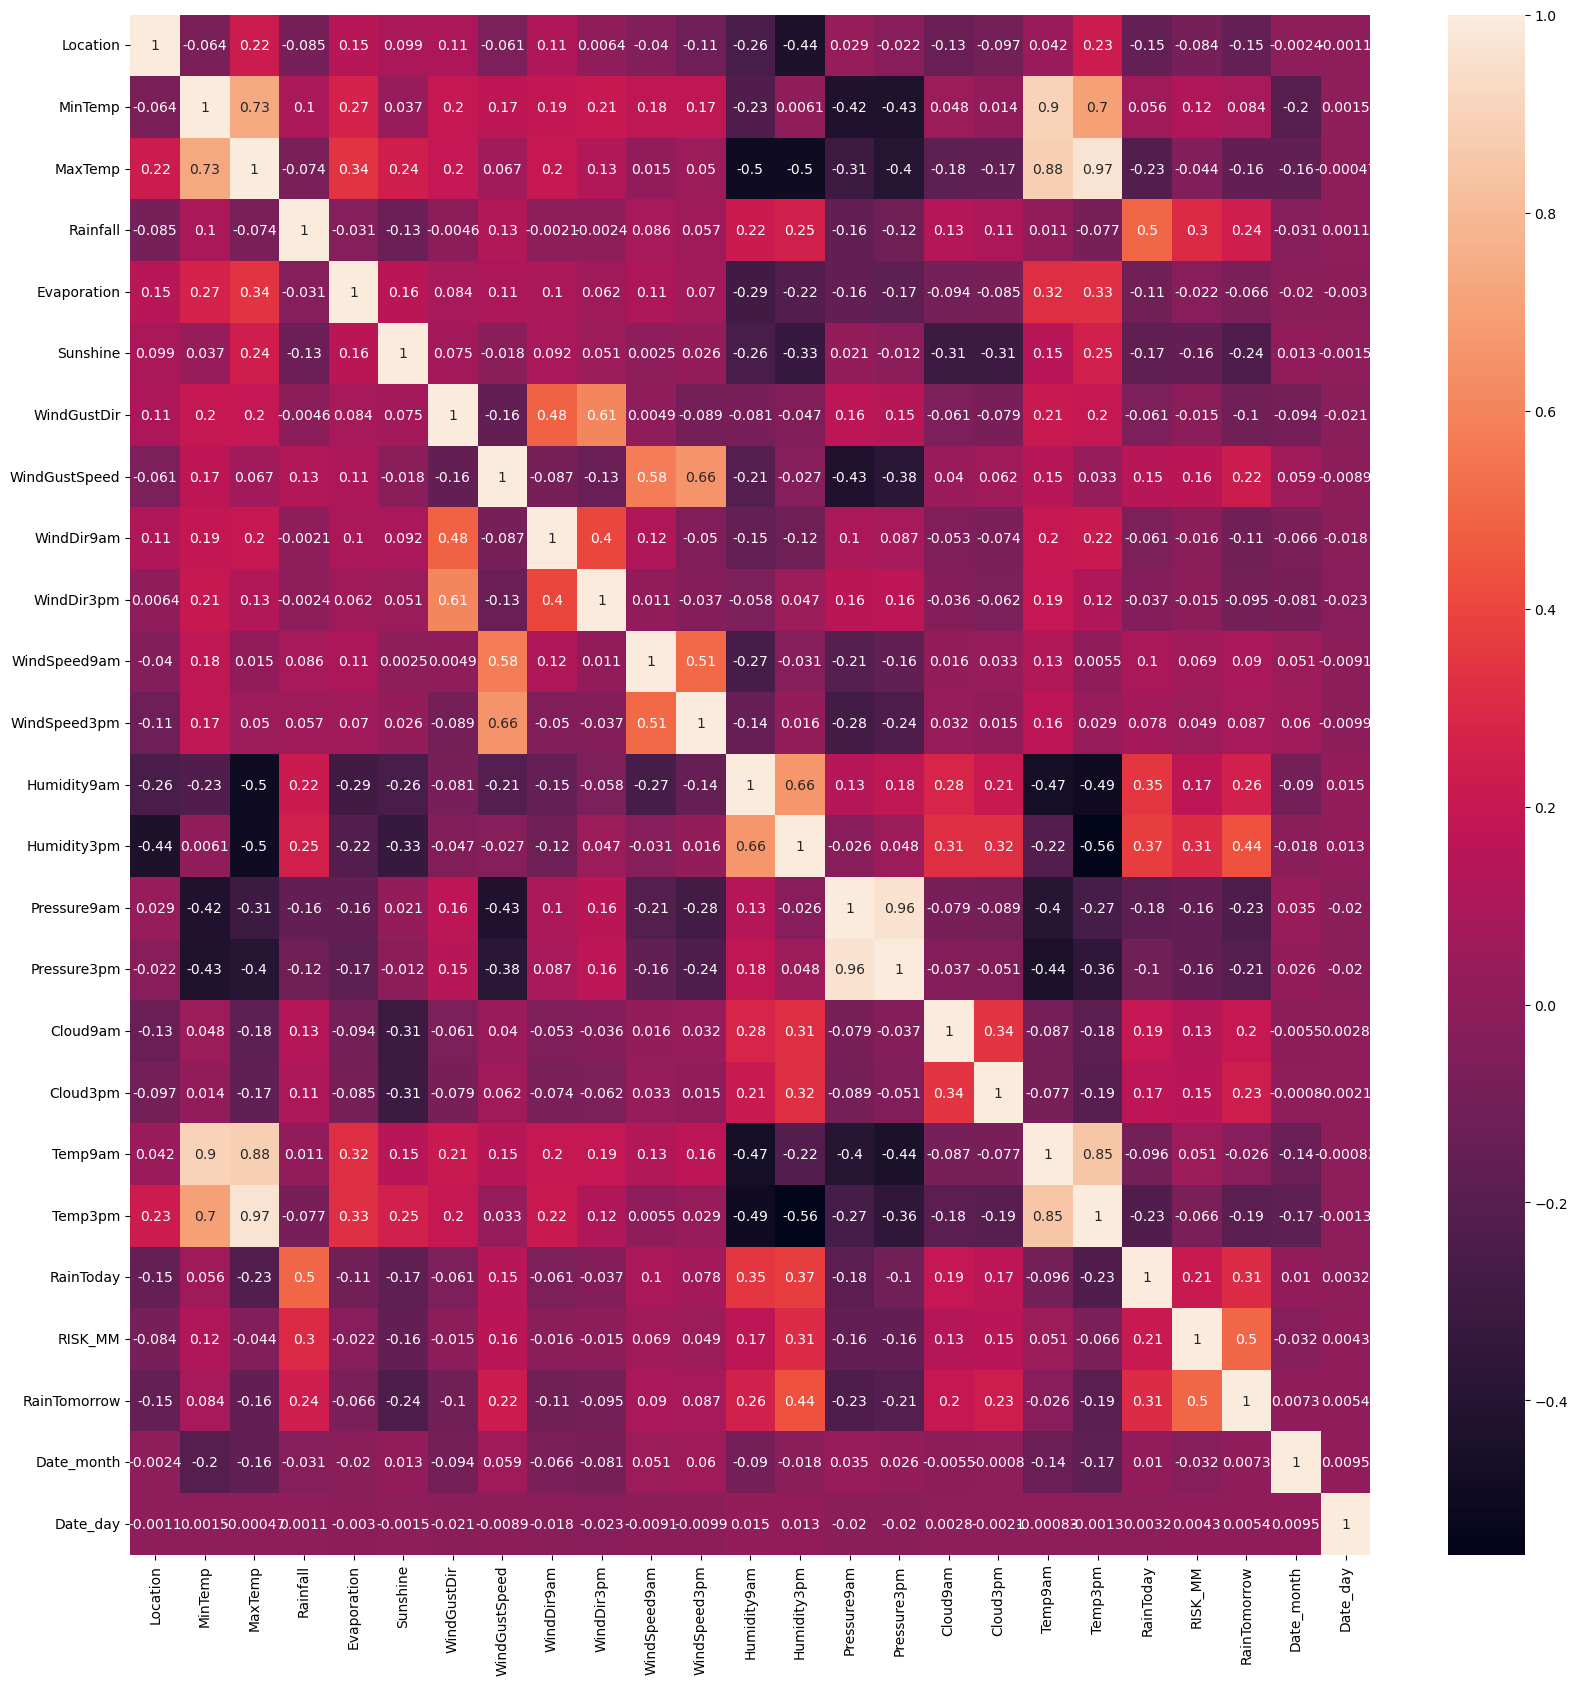

In [27]:
corrmat = df.corr()
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(corrmat,annot=True)

<Axes: ylabel='count'>

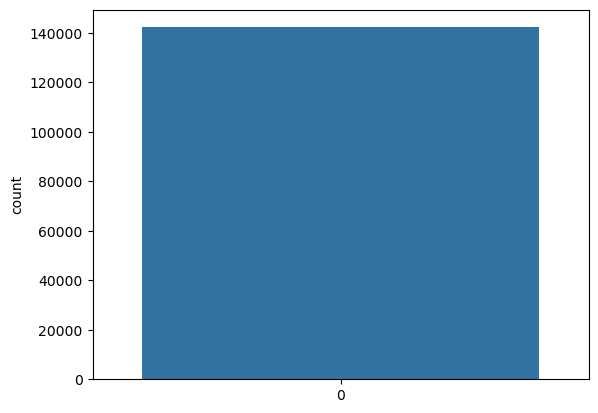

In [33]:
sns.countplot(df["RainTomorrow"])

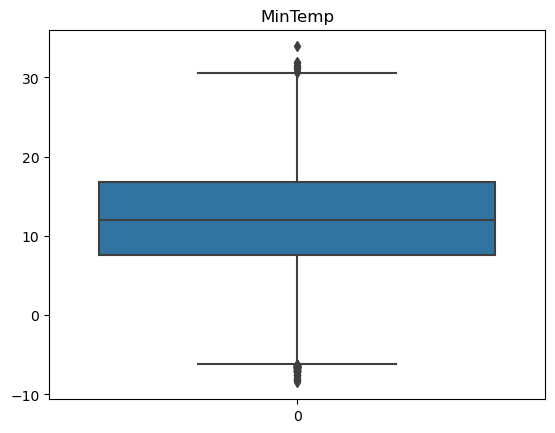

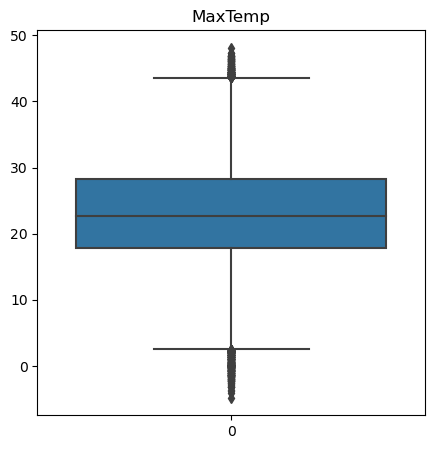

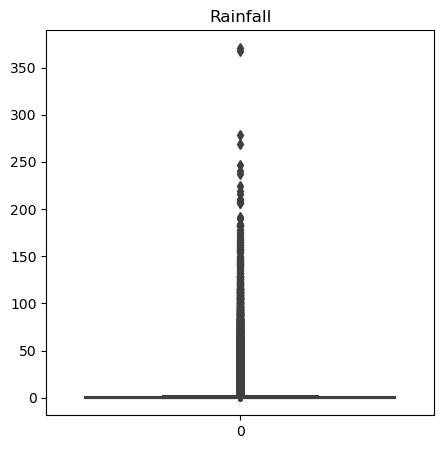

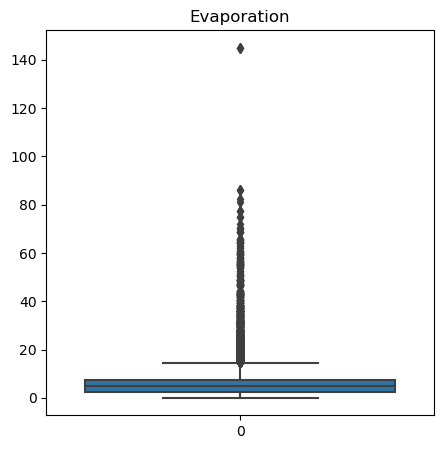

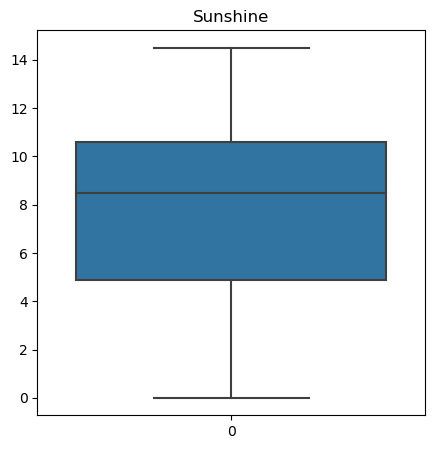

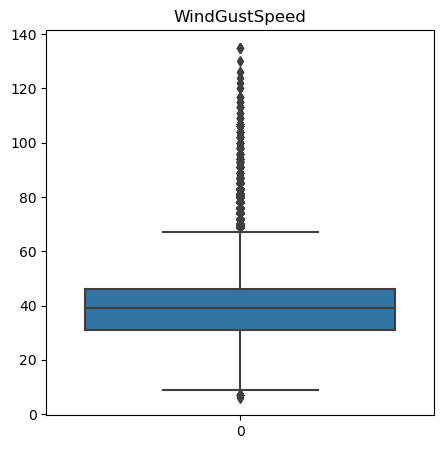

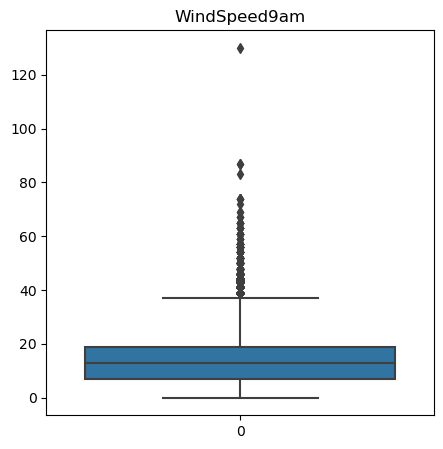

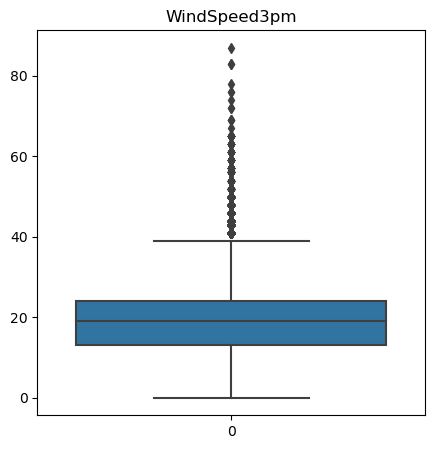

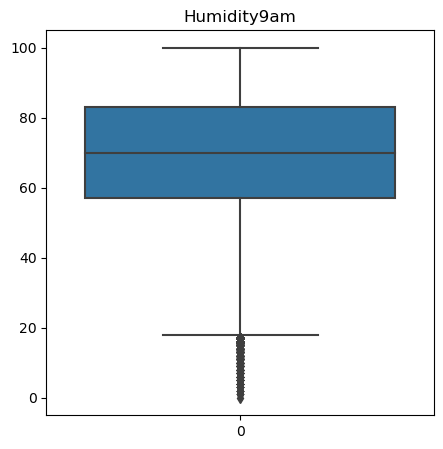

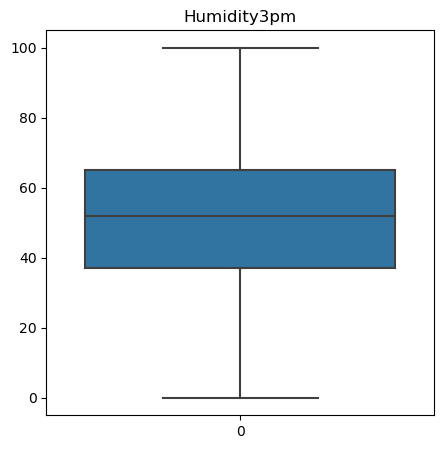

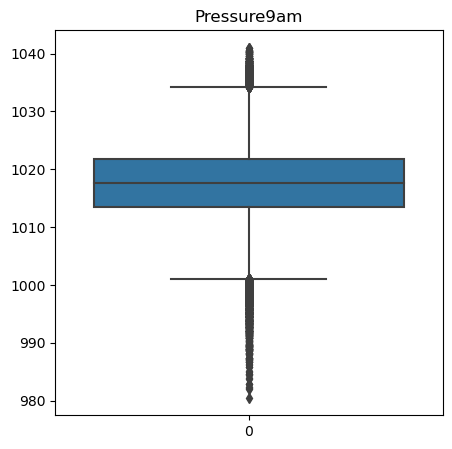

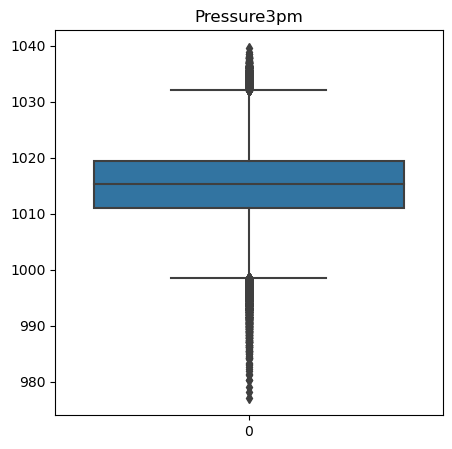

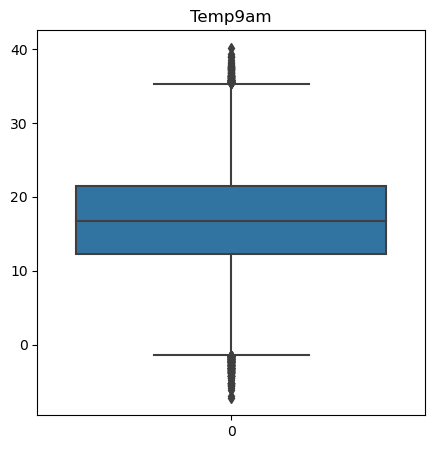

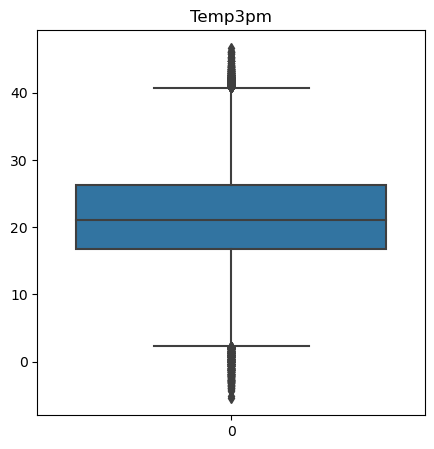

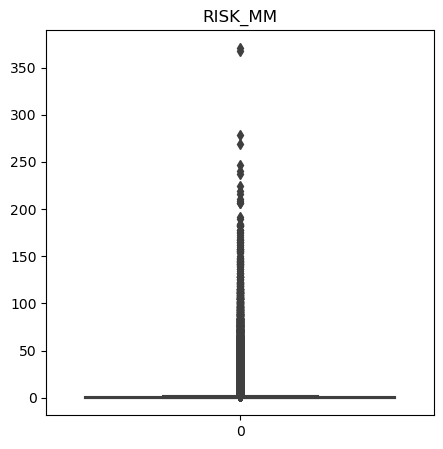

<Figure size 500x500 with 0 Axes>

In [35]:
for feature in continuous_feature:
    data=df.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(5,5))

In [36]:
for feature in continuous_feature:
    print(feature)

MinTemp
MaxTemp
Rainfall
Evaporation
Sunshine
WindGustSpeed
WindSpeed9am
WindSpeed3pm
Humidity9am
Humidity3pm
Pressure9am
Pressure3pm
Temp9am
Temp3pm
RISK_MM


In [37]:
# In order to remove outliers in the dataset, the IQR is calculated.

IQR=df.MinTemp.quantile(0.75)-df.MinTemp.quantile(0.25)
lower_bridge=df.MinTemp.quantile(0.25)-(IQR*1.5)
upper_bridge=df.MinTemp.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-6.200000000000001 30.6


In [38]:
# The upper and lower bridge calculated from the IQR is used to replace the values. The upper bridge replaces all values greater than or equal to it, the lower bridge replaces all vaues lower or equal to it to handle or outliers in the data.
df.loc[df['MinTemp']>=30.6,'MinTemp']=30.6
df.loc[df['MinTemp']<=-6.20,'MinTemp']=-6.20

In [39]:
IQR=df.MaxTemp.quantile(0.75)-df.MaxTemp.quantile(0.25)
lower_bridge=df.MaxTemp.quantile(0.25)-(IQR*1.5)
upper_bridge=df.MaxTemp.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

2.4499999999999975 43.65


In [40]:
df.loc[df['MaxTemp']>=43.65,'MaxTemp']=43.65
df.loc[df['MaxTemp']<=2.45,'MaxTemp']=2.45

In [41]:
IQR=df.Rainfall.quantile(0.75)-df.Rainfall.quantile(0.25)
lower_bridge=df.Rainfall.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Rainfall.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-0.8999999999999999 1.5


In [42]:
df.loc[df['Rainfall']>=1.5,'Rainfall']=1.5
df.loc[df['Rainfall']<=-0.89,'Rainfall']=-0.89

In [43]:
IQR=df.Evaporation.quantile(0.75)-df.Evaporation.quantile(0.25)
lower_bridge=df.Evaporation.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Evaporation.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-4.600000000000001 14.600000000000001


In [44]:
df.loc[df['Evaporation']>=14.6,'Evaporation']=14.6
df.loc[df['Evaporation']<=-4.6,'Evaporation']=-4.6

In [45]:
IQR=df.WindGustSpeed.quantile(0.75)-df.WindGustSpeed.quantile(0.25)
lower_bridge=df.WindGustSpeed.quantile(0.25)-(IQR*1.5)
upper_bridge=df.WindGustSpeed.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

8.5 68.5


In [46]:
df.loc[df['WindGustSpeed']>=68.5,'WindGustSpeed']=68.5
df.loc[df['WindGustSpeed']<=8.5,'WindGustSpeed']=8.5

In [47]:
IQR=df.WindSpeed9am.quantile(0.75)-df.WindSpeed9am.quantile(0.25)
lower_bridge=df.WindSpeed9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.WindSpeed9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-11.0 37.0


In [48]:
df.loc[df['WindSpeed9am']>=37,'WindSpeed9am']=37
df.loc[df['WindSpeed9am']<=-11,'WindSpeed9am']=-11

In [49]:
IQR=df.WindSpeed3pm.quantile(0.75)-df.WindSpeed3pm.quantile(0.25)
lower_bridge=df.WindSpeed3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=df.WindSpeed3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-3.5 40.5


In [50]:
df.loc[df['WindSpeed3pm']>40.5,'WindSpeed3pm']=40.5
df.loc[df['WindSpeed3pm']<=-3.5,'WindSpeed3pm']=-3.5

In [51]:

IQR=df.Humidity9am.quantile(0.75)-df.Humidity9am.quantile(0.25)
lower_bridge=df.Humidity9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Humidity9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

18.0 122.0


In [52]:
df.loc[df['Humidity9am']>=122,'Humidity9am']=122
df.loc[df['Humidity9am']<=18,'Humidity9am']=18

In [53]:
IQR=df.Pressure9am.quantile(0.75)-df.Pressure9am.quantile(0.25)
lower_bridge=df.Pressure9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Pressure9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

1001.0500000000001 1034.25


In [54]:
df.loc[df['Pressure9am']>=1034.25,'Pressure9am']=1034.25
df.loc[df['Pressure9am']<=1001.05,'Pressure9am']=1001.05

In [55]:
IQR=df.Pressure3pm.quantile(0.75)-df.Pressure3pm.quantile(0.25)
lower_bridge=df.Pressure3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Pressure3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

998.4000000000001 1032.0


In [57]:
df.loc[df['Pressure3pm']>=1032,'Pressure3pm']=1032
df.loc[df['Pressure3pm']<=998.4,'Pressure3pm']=998.4

In [58]:
IQR=df.Temp9am.quantile(0.75)-df.Temp9am.quantile(0.25)
lower_bridge=df.Temp9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Temp9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-1.4999999999999982 35.3


In [59]:
df.loc[df['Temp9am']>=35.3,'Temp9am']=35.3
df.loc[df['Temp9am']<=-1.5,'Temp9am']=-1.5

In [60]:
IQR=df.Temp3pm.quantile(0.75)-df.Temp3pm.quantile(0.25)
lower_bridge=df.Temp3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Temp3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

2.299999999999997 40.7


In [62]:
df.loc[df['Temp3pm']>=40.7,'Temp3pm']=40.7
df.loc[df['Temp3pm']<=2.3,'Temp3pm']=2.3

In [66]:
IQR=df.RISK_MM.quantile(0.75)-df.RISK_MM.quantile(0.25)
lower_bridge=df.RISK_MM.quantile(0.25)-(IQR*1.5)
upper_bridge=df.RISK_MM.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-1.2000000000000002 2.0


In [67]:
df.loc[df['RISK_MM']>=2.0,'RISK_MM']=2.0
df.loc[df['RISK_MM']<=-1.2,'RISK_MM']=-1.2

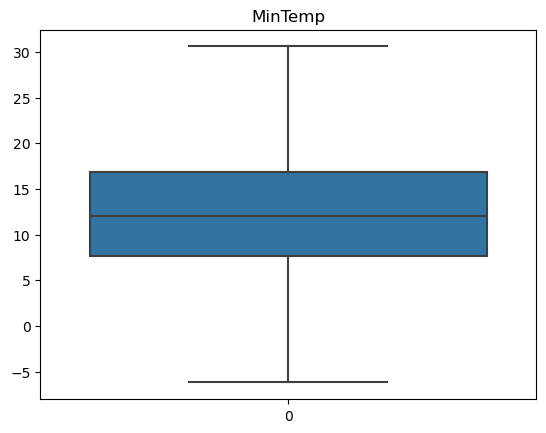

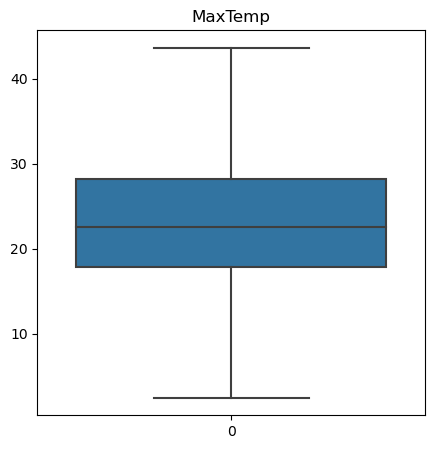

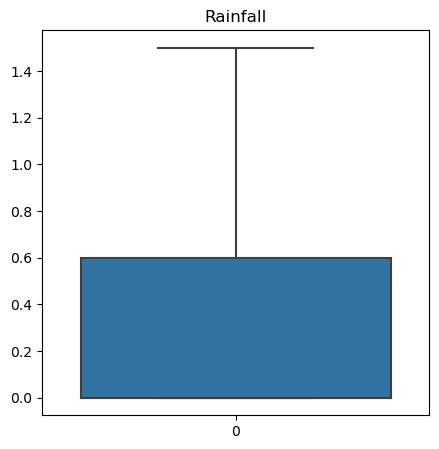

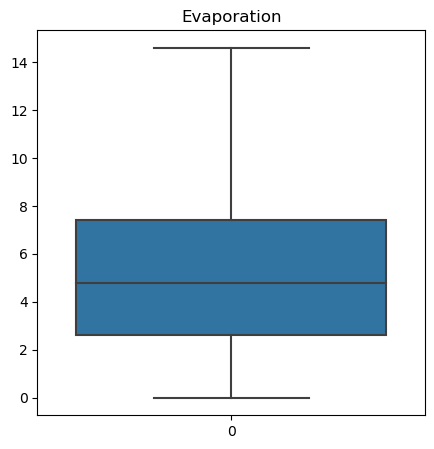

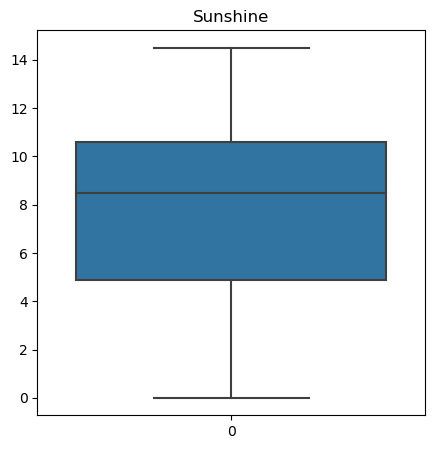

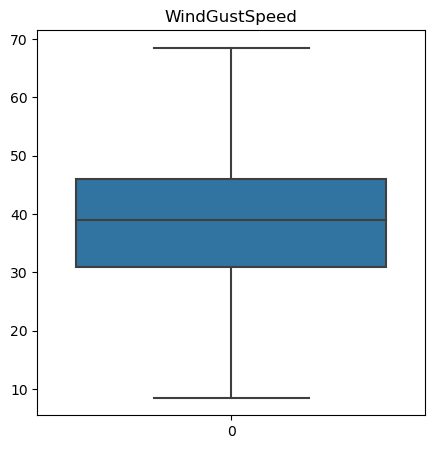

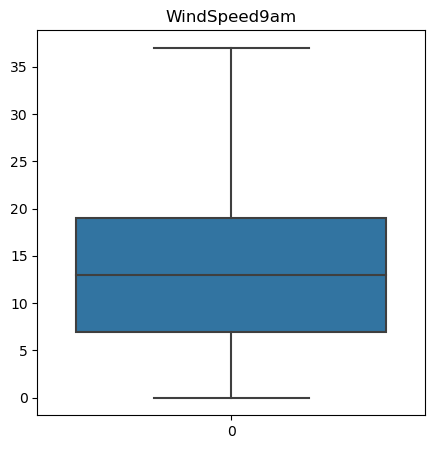

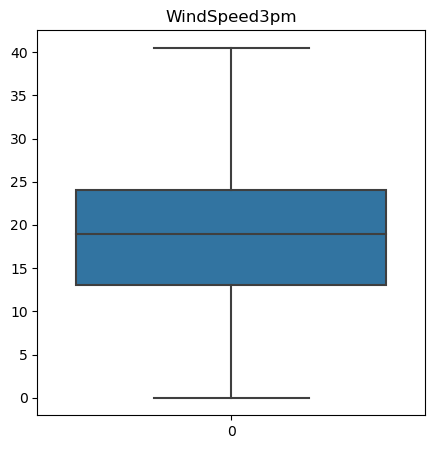

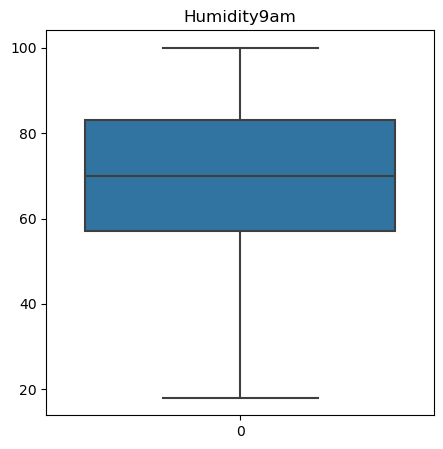

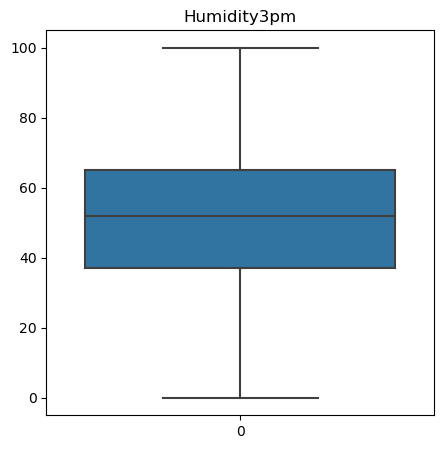

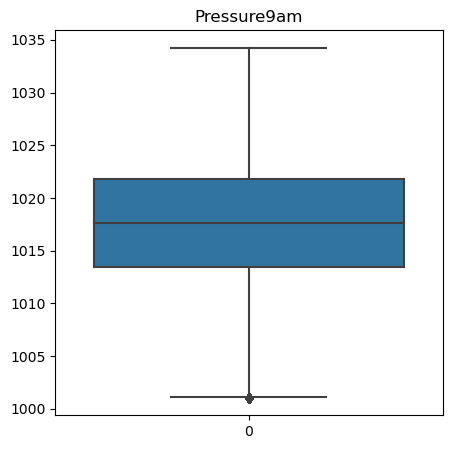

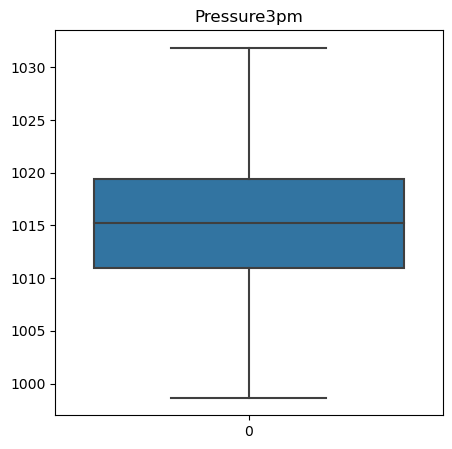

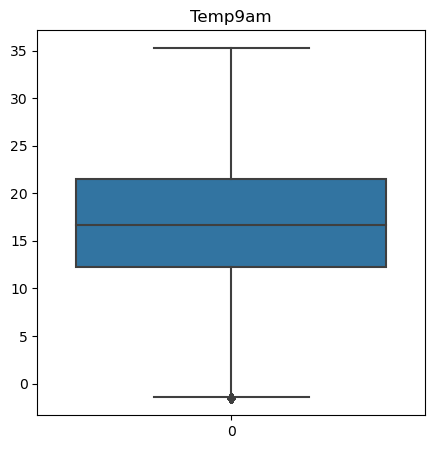

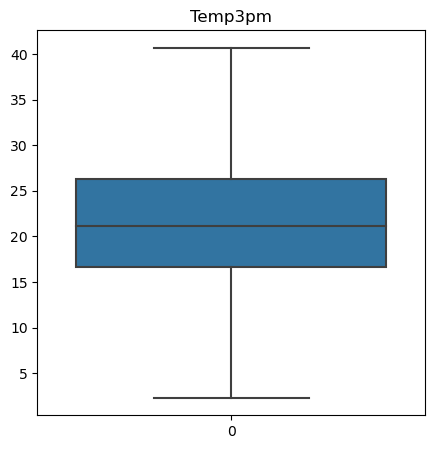

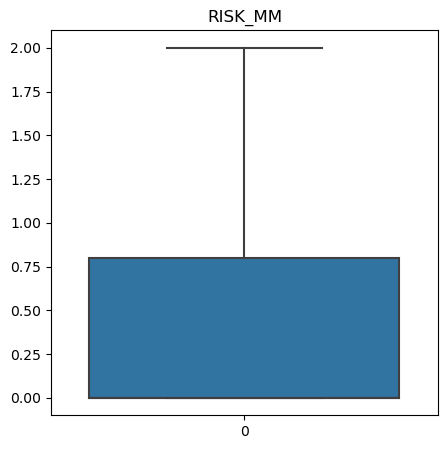

<Figure size 500x500 with 0 Axes>

In [68]:
for feature in continuous_feature:
    data=df.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(5,5))

In [69]:
def qq_plots(df, variable):
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

MinTemp


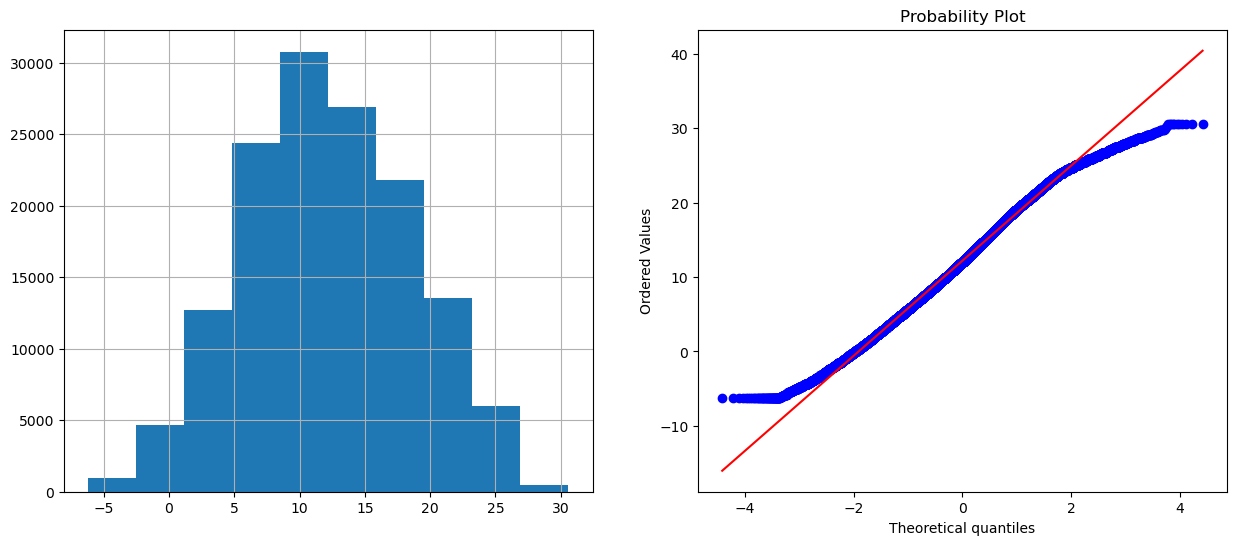

MaxTemp


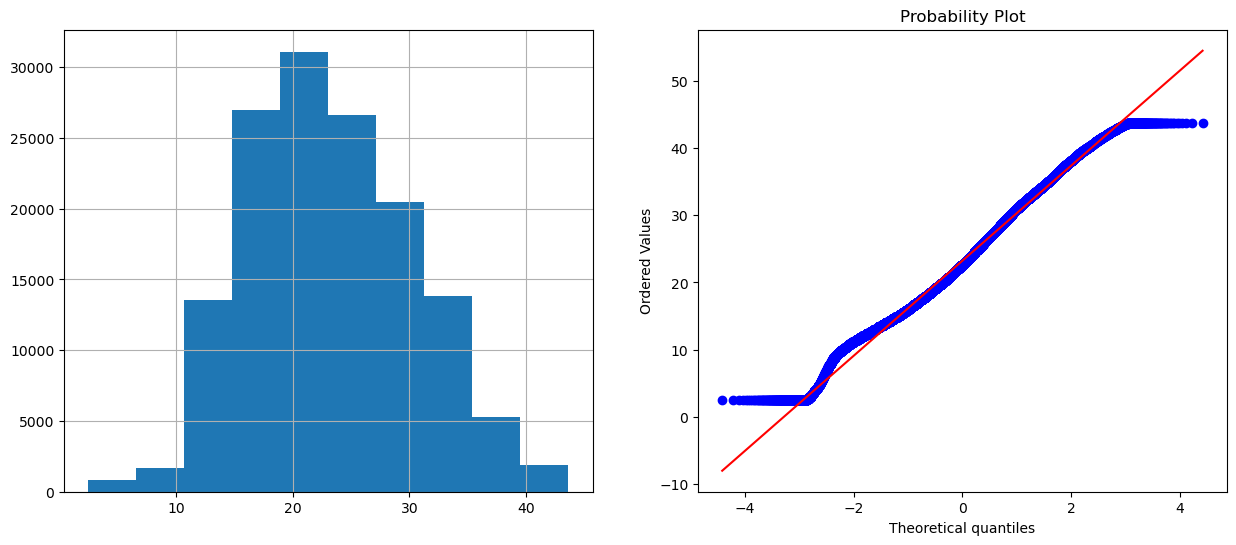

Rainfall


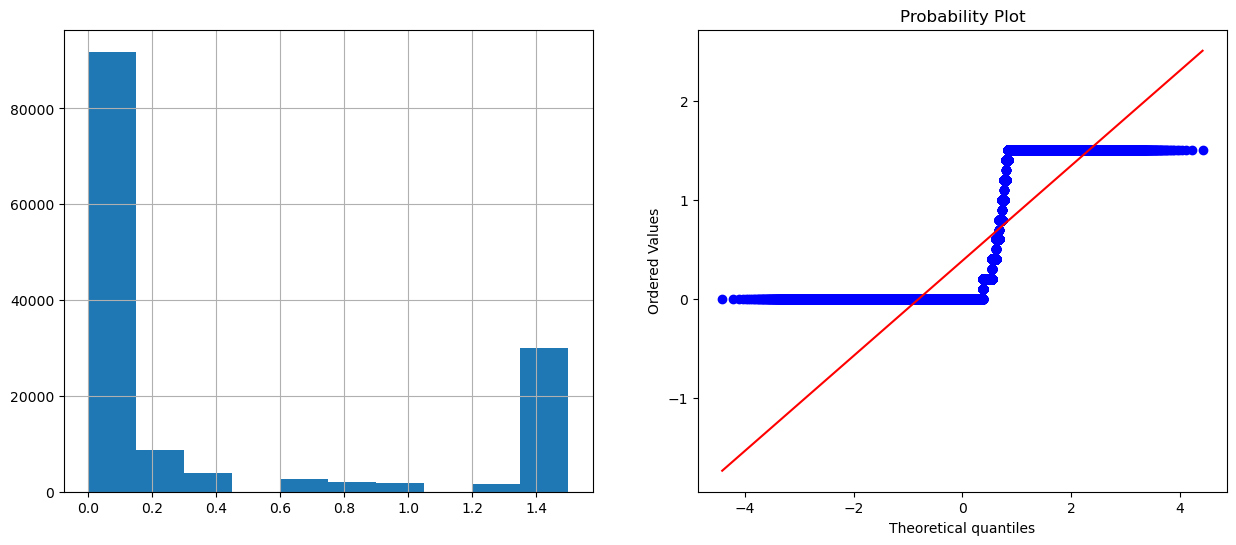

Evaporation


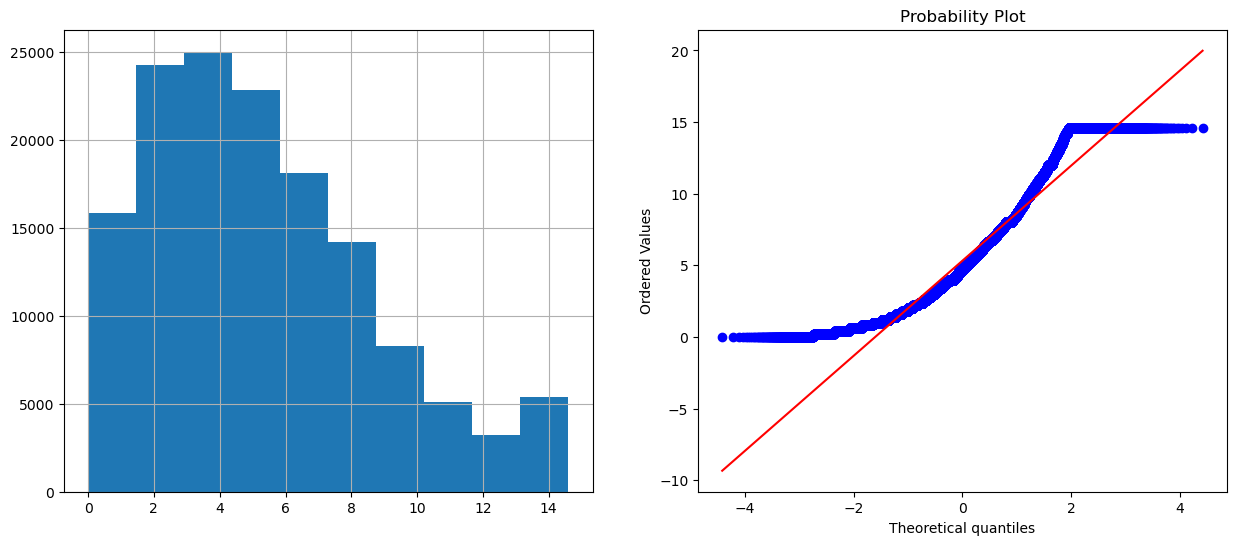

Sunshine


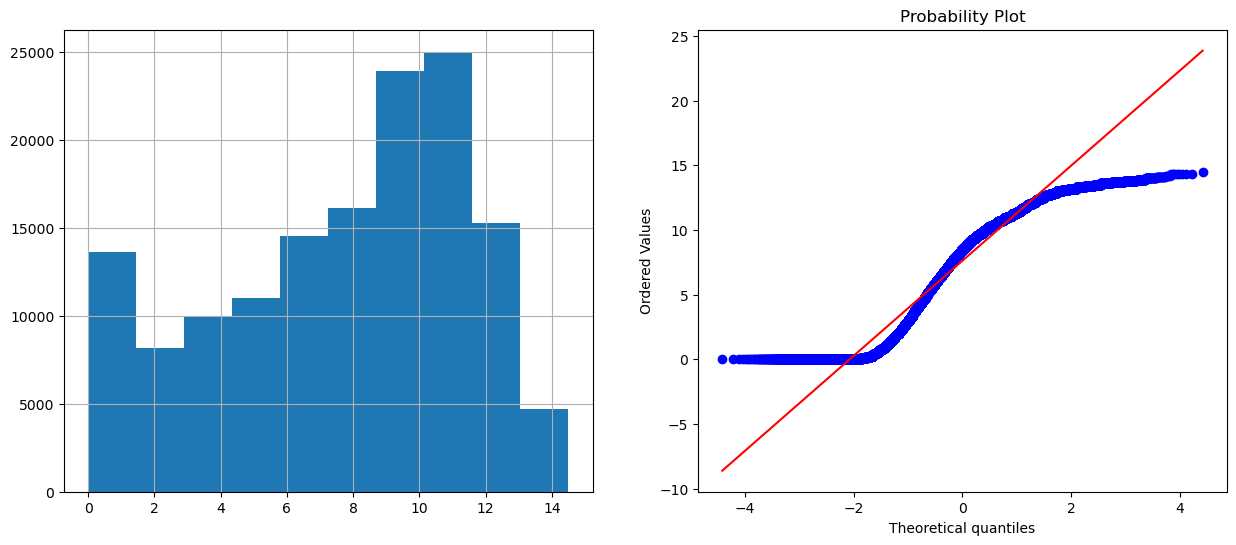

WindGustSpeed


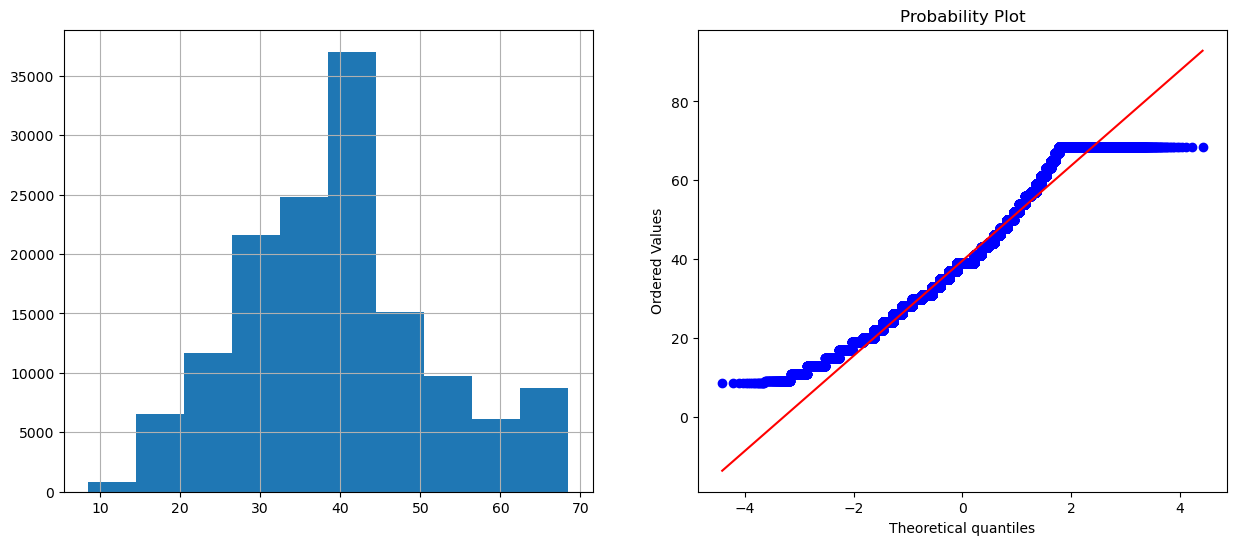

WindSpeed9am


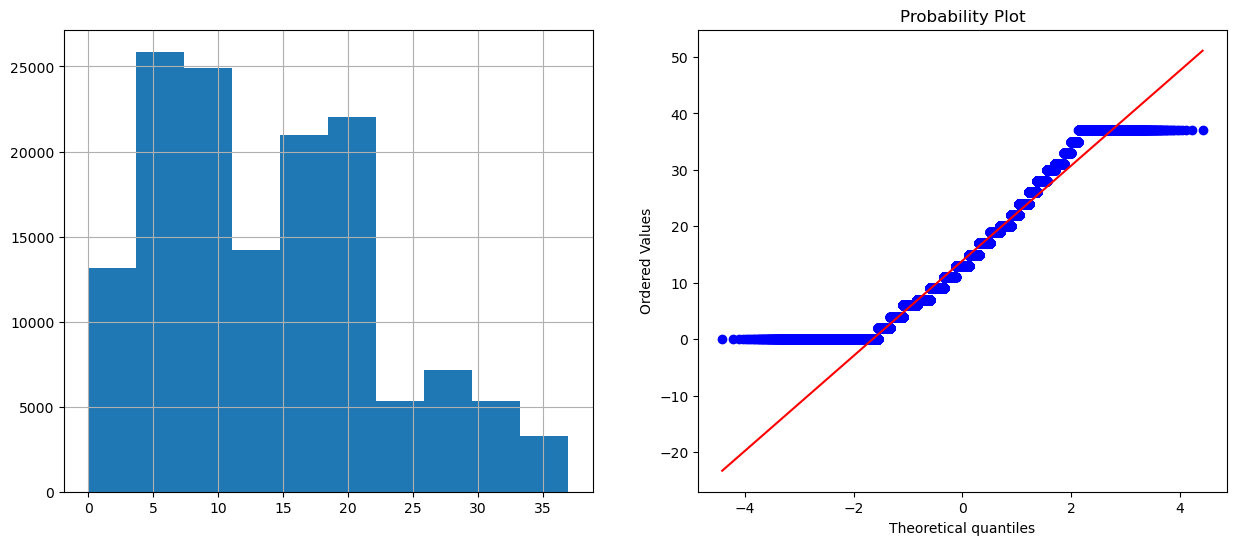

WindSpeed3pm


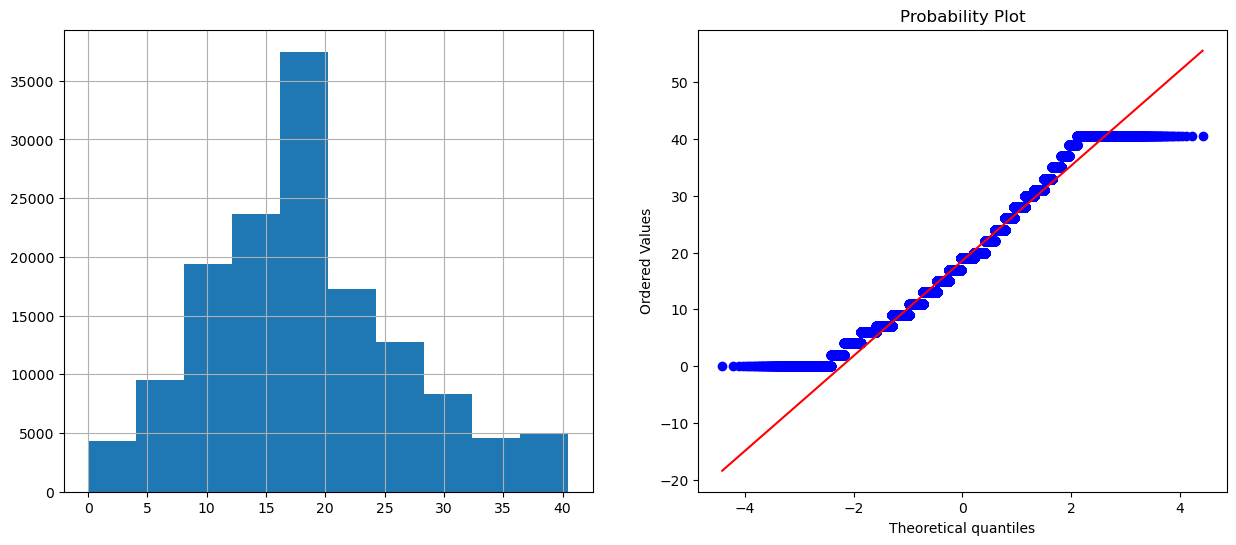

Humidity9am


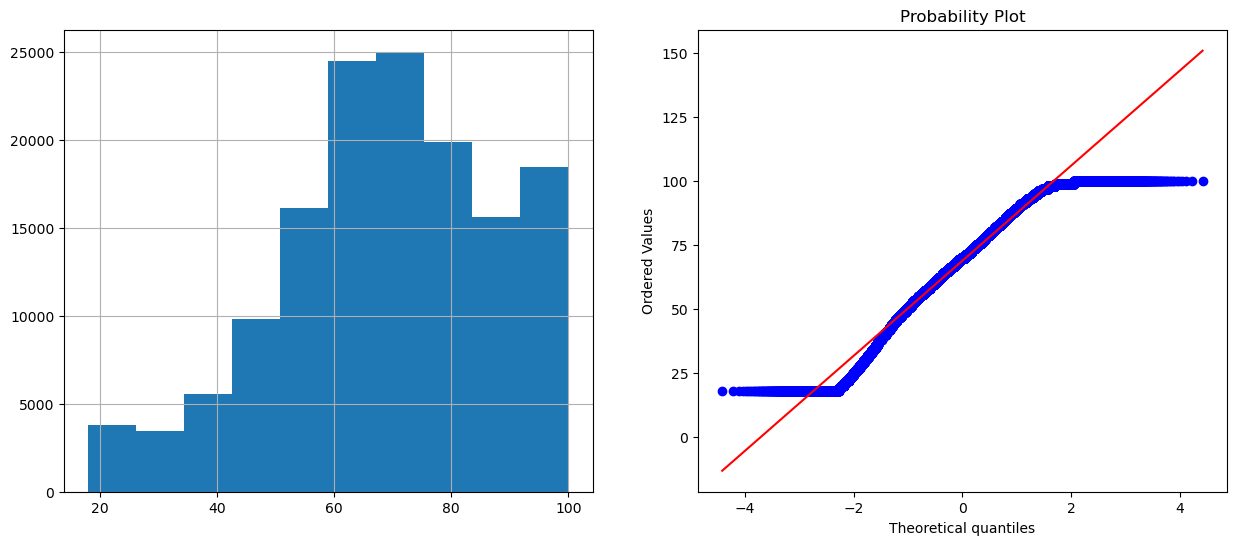

Humidity3pm


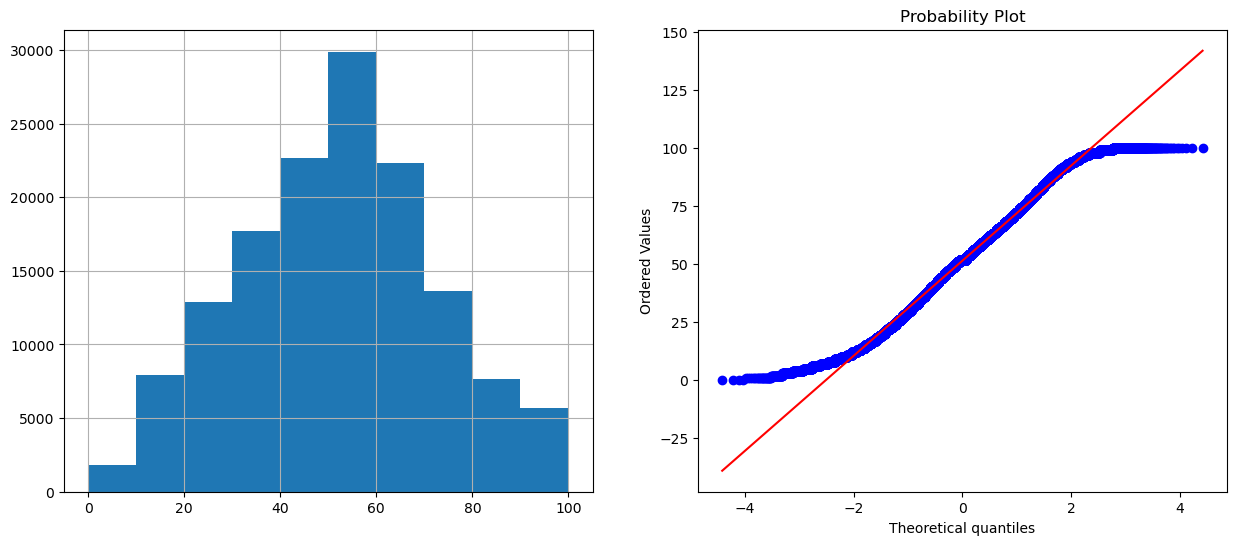

Pressure9am


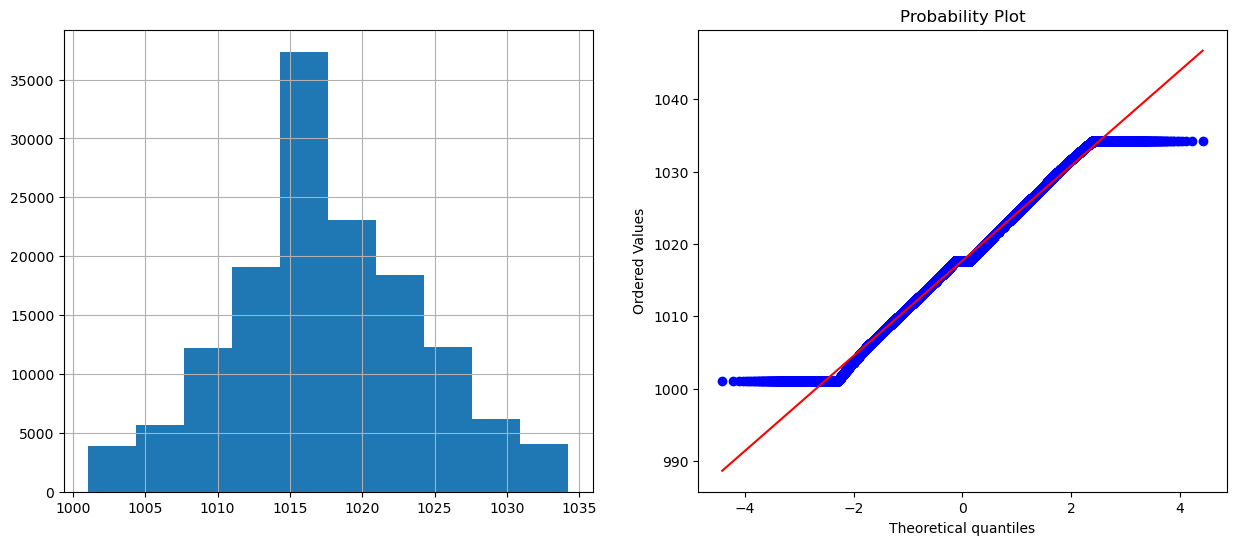

Pressure3pm


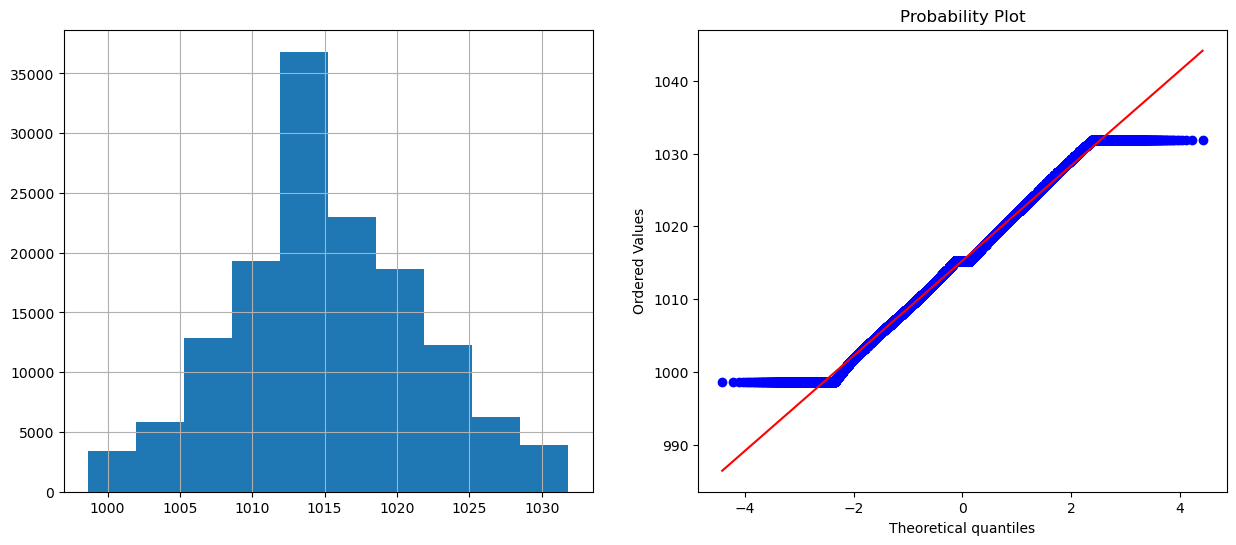

Temp9am


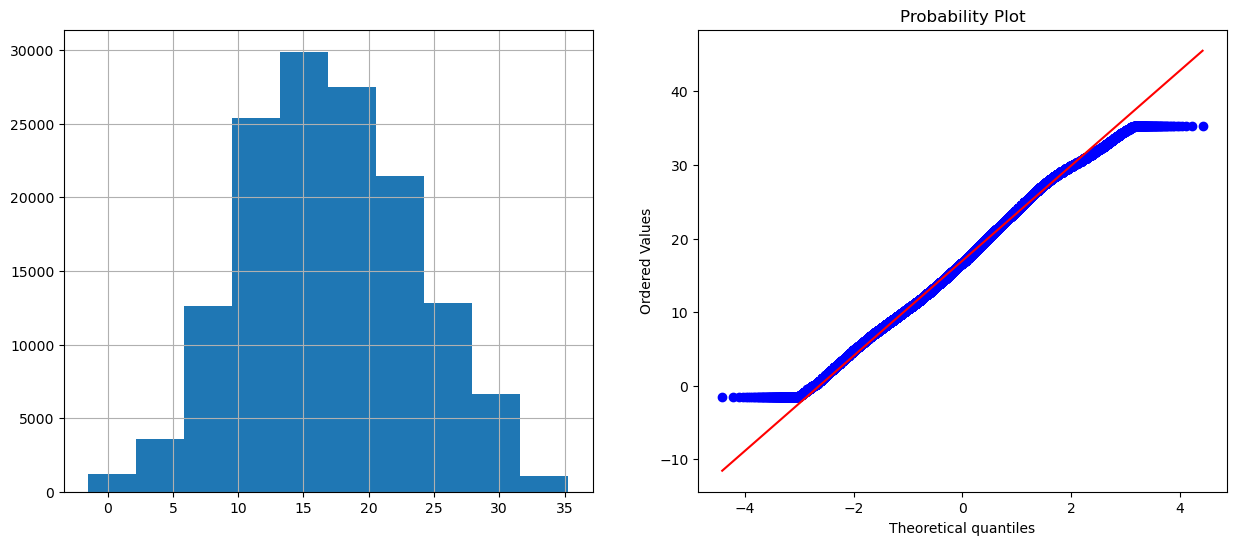

Temp3pm


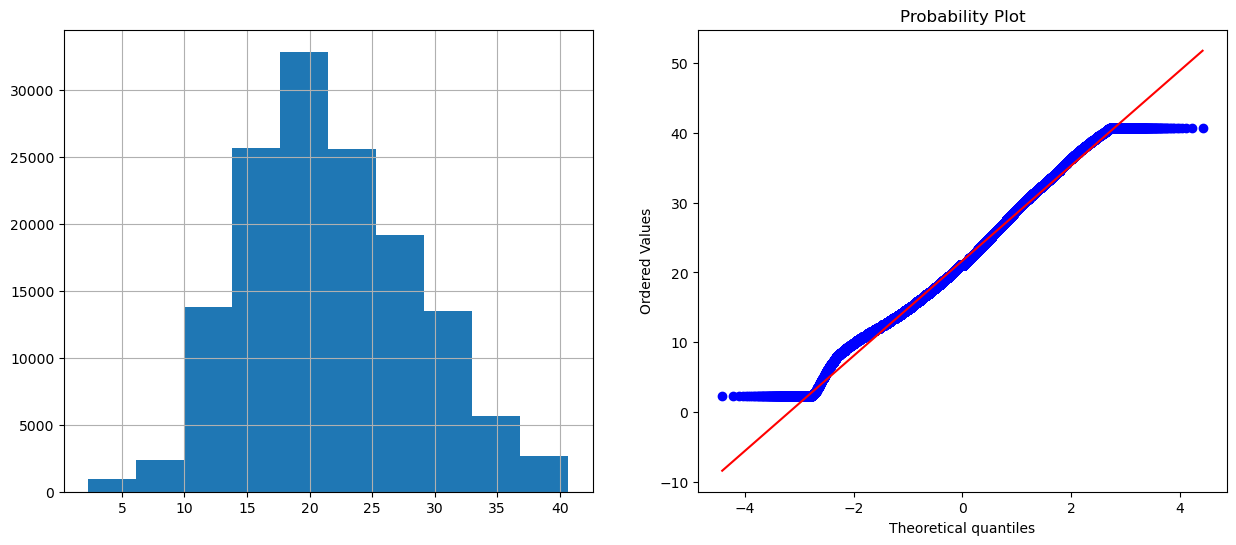

RISK_MM


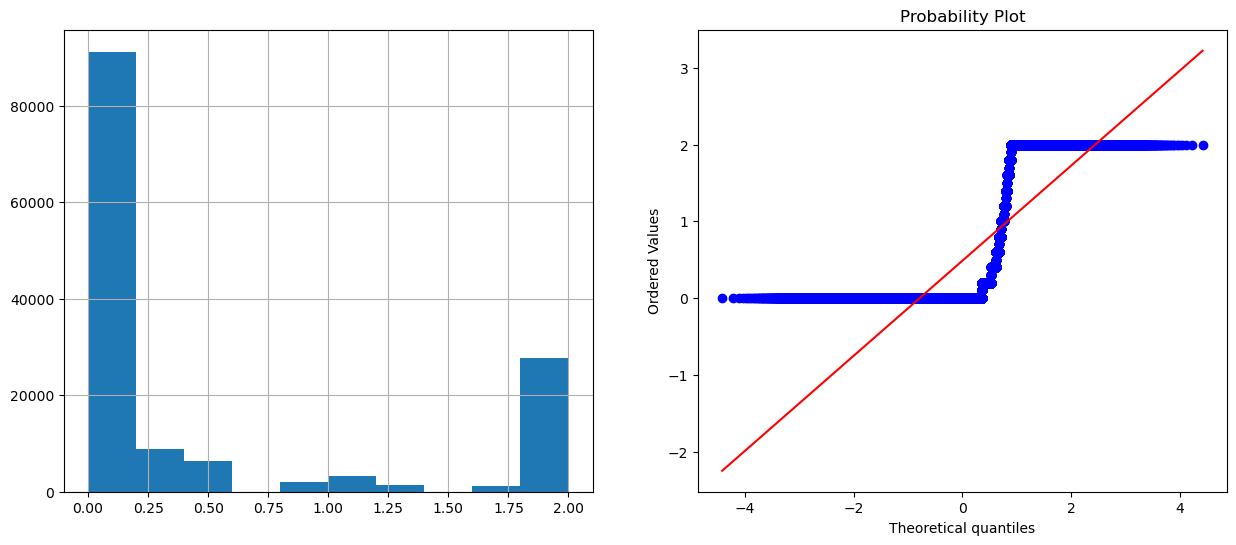

In [70]:
for feature in continuous_feature:
    print(feature)
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[feature].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(df[feature], dist="norm", plot=plt)
    plt.show()

In [71]:
df.to_csv("preprocessed_1.csv", index=False)

In [72]:
X = df.drop(["RainTomorrow", "Date"], axis=1) # Independent Variable
Y = df["RainTomorrow"] # Variable to be predicted

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size =0.2, stratify = Y, random_state = 0)

In [75]:
# SMOTE is used when dealing with unbalanced datasets
sm=SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_res)))

c:\Users\Idowu Mariam\miniconda3\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Idowu Mariam\miniconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


The number of classes before fit Counter({0: 88252, 1: 25502})
The number of classes after fit Counter({1: 88252, 0: 88252})


In [76]:
rf=RandomForestClassifier()
rf.fit(X_train_res,y_train_res)

RandomForestClassifier()

In [77]:
y_pred1 = rf.predict(X_test)
print(confusion_matrix(y_test,y_pred1))
print(accuracy_score(y_test,y_pred1))
print(classification_report(y_test,y_pred1))

[[22064     0]
 [    0  6375]]
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22064
           1       1.00      1.00      1.00      6375

    accuracy                           1.00     28439
   macro avg       1.00      1.00      1.00     28439
weighted avg       1.00      1.00      1.00     28439



1.0

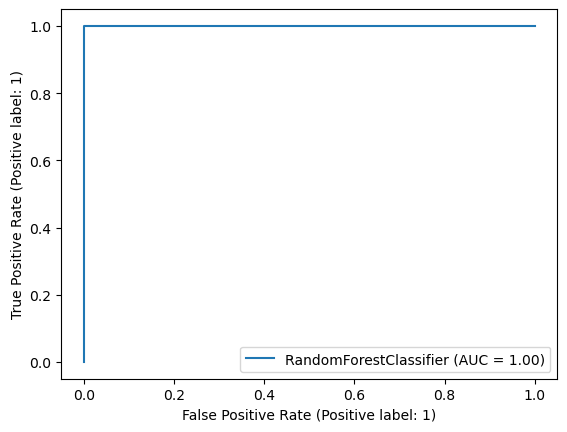

In [95]:
metrics.RocCurveDisplay.from_estimator(rf, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred1, average=None) 

In [96]:
logreg = LogisticRegression()
logreg.fit(X_train_res, y_train_res)

c:\Users\Idowu Mariam\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [97]:
y_pred2 = logreg.predict(X_test)
print(confusion_matrix(y_test,y_pred2))
print(accuracy_score(y_test,y_pred2))
print(classification_report(y_test,y_pred2))

[[21857   207]
 [   80  6295]]
0.9899082246211189
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     22064
           1       0.97      0.99      0.98      6375

    accuracy                           0.99     28439
   macro avg       0.98      0.99      0.99     28439
weighted avg       0.99      0.99      0.99     28439



0.9890345909937578

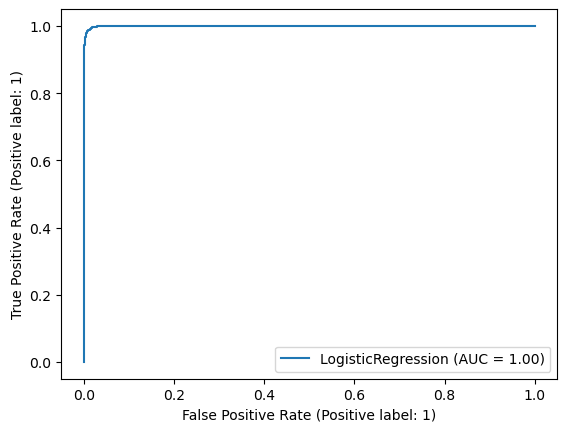

In [98]:
metrics.RocCurveDisplay.from_estimator(logreg, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred2, average=None) 

In [99]:
gnb = GaussianNB()
gnb.fit(X_train_res, y_train_res)

GaussianNB()

In [101]:
y_pred3 = gnb.predict(X_test)
print(confusion_matrix(y_test,y_pred3))
print(accuracy_score(y_test,y_pred3))
print(classification_report(y_test,y_pred3))

[[21866   198]
 [    2  6373]]
0.992967403917156
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     22064
           1       0.97      1.00      0.98      6375

    accuracy                           0.99     28439
   macro avg       0.98      1.00      0.99     28439
weighted avg       0.99      0.99      0.99     28439



0.9953561901918127

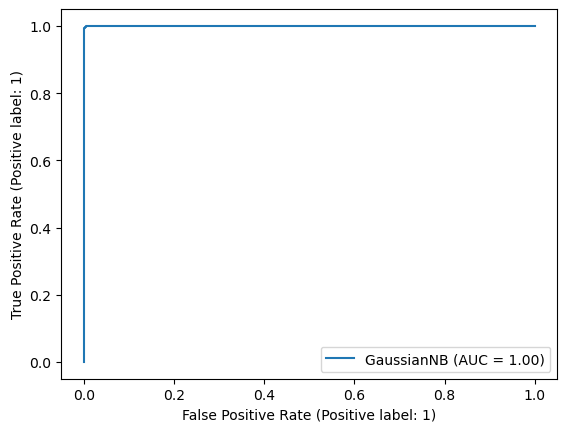

In [108]:
from sklearn.metrics import mean_squared_error
metrics.RocCurveDisplay.from_estimator(gnb, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred3, average=None) 

In [109]:
metrics.mean_squared_error(y_test,y_pred3)

0.007032596082843982

In [110]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_res, y_train_res)

KNeighborsClassifier(n_neighbors=3)

In [112]:
y_pred4 = knn.predict(X_test.values)
print(confusion_matrix(y_test,y_pred4))
print(accuracy_score(y_test,y_pred4))
print(classification_report(y_test,y_pred4))

c:\Users\Idowu Mariam\miniconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


[[17217  4847]
 [ 1712  4663]]
0.7693660114631317
              precision    recall  f1-score   support

           0       0.91      0.78      0.84     22064
           1       0.49      0.73      0.59      6375

    accuracy                           0.77     28439
   macro avg       0.70      0.76      0.71     28439
weighted avg       0.82      0.77      0.78     28439



c:\Users\Idowu Mariam\miniconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


0.7558859325456071

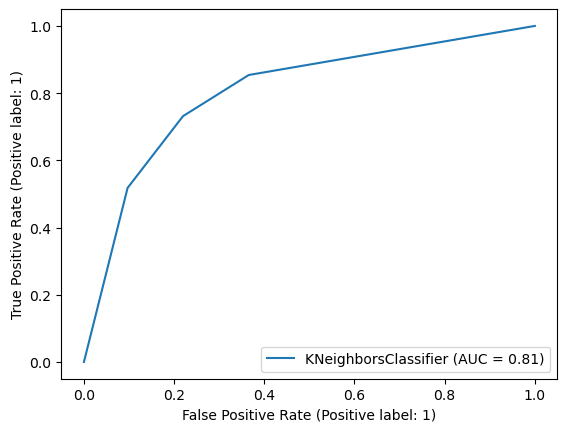

In [114]:
metrics.RocCurveDisplay.from_estimator(knn, X_test.values, y_test.values)
metrics.roc_auc_score(y_test, y_pred4, average=None) 